# Installs & Imports

In [1]:
# Install packages
# !pip install pandas numpy matplotlib seaborn scipy scikit-learn openpyxl


In [2]:
# Standard library
import os
import copy
import pickle
import json
from pathlib import Path
from datetime import datetime

# Core data & viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Stats 
from scipy import stats

# Scikit-learn 
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (
    ElasticNet, ElasticNetCV, Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split, learning_curve
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Utility Functions

In [3]:
def huber_loss(y_true, y_pred, delta=1.0):
    """Calculate Huber loss manually for comparison"""
    error = y_true - y_pred
    is_small = np.abs(error) <= delta
    loss = np.where(is_small, 0.5 * error**2, delta * (np.abs(error) - 0.5 * delta))
    return np.mean(loss)


def calculate_all_metrics(y_true, y_pred, prefix=""):
    """Calculate comprehensive regression metrics including regulatory context"""
    metrics = {
        f'{prefix}RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        f'{prefix}MAE': mean_absolute_error(y_true, y_pred),
        f'{prefix}R2': r2_score(y_true, y_pred),
        f'{prefix}Huber': huber_loss(y_true, y_pred),
        f'{prefix}MSE': mean_squared_error(y_true, y_pred)
    }
    
    # Add regulatory classification metrics for Quote predictions
    if isinstance(y_true, (pd.Series, np.ndarray)):
        # Regulatory threshold classification accuracy
        true_insolvent = (y_true < 0)
        pred_insolvent = (y_pred < 0)
        true_undercap = (y_true < 1)
        pred_undercap = (y_pred < 1)
        true_wellcap = (y_true > 2)
        pred_wellcap = (y_pred > 2)
        
        if len(y_true) > 0:
            metrics[f'{prefix}Insolvent_Accuracy'] = np.mean(true_insolvent == pred_insolvent)
            metrics[f'{prefix}Undercap_Accuracy'] = np.mean(true_undercap == pred_undercap)
            metrics[f'{prefix}WellCap_Accuracy'] = np.mean(true_wellcap == pred_wellcap)
            
            # MAPE for non-zero values (avoid division by zero)
            nonzero_mask = y_true != 0
            if np.sum(nonzero_mask) > 0:
                mape = np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100
                metrics[f'{prefix}MAPE'] = mape
    
    return metrics


In [4]:
def analyze_regulatory_performance(y_true, y_pred, target_name="Quote"):
    """Analyze model performance across regulatory categories"""
    
    # Define regulatory categories
    categories = {
        'Insolvent': y_true < 0,
        'Undercapitalized': (y_true >= 0) & (y_true < 1),
        'Adequate': (y_true >= 1) & (y_true <= 2),
        'Well-Capitalized': y_true > 2
    }
    
    print(f"\nREGULATORY PERFORMANCE ANALYSIS - {target_name}")
    
    results = {}
    for category, mask in categories.items():
        if np.sum(mask) > 0:
            y_true_cat = y_true[mask]
            y_pred_cat = y_pred[mask]
            
            rmse = np.sqrt(mean_squared_error(y_true_cat, y_pred_cat))
            mae = mean_absolute_error(y_true_cat, y_pred_cat)
            r2 = r2_score(y_true_cat, y_pred_cat)
            
            results[category] = {
                'count': np.sum(mask),
                'percentage': np.sum(mask) / len(y_true) * 100,
                'RMSE': rmse,
                'MAE': mae,
                'R2': r2
            }
            
            print(f"\n{category} ({np.sum(mask)} obs, {np.sum(mask)/len(y_true)*100:.1f}%):")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  R²: {r2:.4f}")
    
    return results


In [5]:
def plot_learning_curves(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error'):
    """Plot learning curves for model diagnosis"""

    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv, scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=8
    )
    
    train_mean = -train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = -val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.1, color='blue')
    plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.1, color='red')
    plt.xlabel('Training Set Size')
    plt.ylabel('MSE')
    plt.title('Learning Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)
    return plt.gcf()

def plot_residuals(y_true, y_pred, title="Residual Plot"):
    """Create residual plots for model diagnosis with legends"""
    residuals = y_true - y_pred
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Residuals vs Predicted with color coding
    # Color code by residual magnitude
    abs_residuals = np.abs(residuals)
    colors = plt.cm.viridis(abs_residuals / abs_residuals.max())
    
    scatter = ax1.scatter(y_pred, residuals, alpha=0.6, c=colors, s=30)
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')
    
    # Add trend line
    z = np.polyfit(y_pred, residuals, 1)
    p = np.poly1d(z)
    ax1.plot(y_pred, p(y_pred), "orange", linestyle='-', linewidth=2, 
            label=f'Trend Line (slope: {z[0]:.4f})')
    
    ax1.set_xlabel('Predicted Values')
    ax1.set_ylabel('Residuals')
    ax1.set_title(f'{title} - Residuals vs Predicted')
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar for residual magnitude
    cbar = plt.colorbar(scatter, ax=ax1, shrink=0.8)
    cbar.set_label('Absolute Residual Magnitude', rotation=270, labelpad=20)
    
    # Residual distribution with enhanced styling
    n, bins, patches = ax2.hist(residuals, bins=30, alpha=0.7, density=True, 
                            color='skyblue', edgecolor='black', linewidth=0.5)
    
    # Add normal distribution overlay
    mu, sigma = residuals.mean(), residuals.std()
    x = np.linspace(residuals.min(), residuals.max(), 100)
    normal_dist = ((1/(sigma * np.sqrt(2 * np.pi))) * 
                   np.exp(-0.5 * ((x - mu) / sigma) ** 2))
    ax2.plot(x, normal_dist, 'red', linewidth=2, 
            label=f'Normal Fit (μ={mu:.3f}, σ={sigma:.3f})')
    
    # Add mean and median lines
    ax2.axvline(mu, color='red', linestyle='--', linewidth=2, alpha=0.8, label=f'Mean: {mu:.3f}')
    ax2.axvline(np.median(residuals), color='orange', linestyle='--', linewidth=2, alpha=0.8, 
            label=f'Median: {np.median(residuals):.3f}')
    
    ax2.set_xlabel('Residuals')
    ax2.set_ylabel('Density')
    ax2.set_title(f'{title} - Residual Distribution')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig



In [6]:
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual", 
                                     scale_type="original", target_scalers=None):
    """Enhanced plotting with optional target_scalers parameter"""
    
    if 'Quote' in title:
        if scale_type == "original":
            # Original scale thresholds
            insolvent_mask = y_true < 0
            undercap_mask = (y_true >= 0) & (y_true < 1)
            adequate_mask = (y_true >= 1) & (y_true <= 2)
            wellcap_mask = y_true > 2
        else:
            # Normalized scale thresholds
            if target_scalers and 'quote' in target_scalers:
                try:
                    quote_scaler = target_scalers['quote']
                    threshold_0_norm = quote_scaler.transform([[0]])[0][0]
                    threshold_1_norm = quote_scaler.transform([[1]])[0][0]
                    threshold_2_norm = quote_scaler.transform([[2]])[0][0]
                    
                    insolvent_mask = y_true < threshold_0_norm
                    undercap_mask = (y_true >= threshold_0_norm) & (y_true < threshold_1_norm)
                    adequate_mask = (y_true >= threshold_1_norm) & (y_true <= threshold_2_norm)
                    wellcap_mask = y_true > threshold_2_norm
                except Exception as e:
                    print(f"Warning: Could not use target_scalers ({e}), falling back to quartiles")
                    # Fallback to quartiles
                    q25, q50, q75 = np.percentile(y_true, [25, 50, 75])
                    insolvent_mask = y_true <= q25
                    undercap_mask = (y_true > q25) & (y_true <= q50)
                    adequate_mask = (y_true > q50) & (y_true <= q75)
                    wellcap_mask = y_true > q75
            else:
                print("Warning: target_scalers not provided, using quartiles for normalized scale")
                # Fallback to quartiles
                q25, q50, q75 = np.percentile(y_true, [25, 50, 75])
                insolvent_mask = y_true <= q25
                undercap_mask = (y_true > q25) & (y_true <= q50)
                adequate_mask = (y_true > q50) & (y_true <= q75)
                wellcap_mask = y_true > q75
                
        # Plot each category separately for proper legend
        if np.sum(insolvent_mask) > 0:
            plt.scatter(y_true[insolvent_mask], y_pred[insolvent_mask], 
                       alpha=0.7, s=25, c='red', label='Insolvent', marker='o')
        if np.sum(undercap_mask) > 0:
            plt.scatter(y_true[undercap_mask], y_pred[undercap_mask], 
                       alpha=0.7, s=25, c='orange', label='Undercapitalized', marker='s')
        if np.sum(adequate_mask) > 0:
            plt.scatter(y_true[adequate_mask], y_pred[adequate_mask], 
                       alpha=0.7, s=25, c='gold', label='Adequate', marker='^')
        if np.sum(wellcap_mask) > 0:
            plt.scatter(y_true[wellcap_mask], y_pred[wellcap_mask], 
                       alpha=0.7, s=25, c='green', label='Well-Capitalized', marker='D')
        
        # Add threshold lines
        if scale_type == "original":
            plt.axhline(y=0, color='red', linestyle=':', alpha=0.7, linewidth=1)
            plt.axhline(y=1, color='orange', linestyle=':', alpha=0.7, linewidth=1)
            plt.axhline(y=2, color='green', linestyle=':', alpha=0.7, linewidth=1)
            plt.axvline(x=0, color='red', linestyle=':', alpha=0.7, linewidth=1)
            plt.axvline(x=1, color='orange', linestyle=':', alpha=0.7, linewidth=1)
            plt.axvline(x=2, color='green', linestyle=':', alpha=0.7, linewidth=1)
        
    else:
        # For non-Quote targets, use quartile-based coloring
        q25, q50, q75 = np.percentile(y_true, [25, 50, 75])
        
        q1_mask = y_true <= q25
        q2_mask = (y_true > q25) & (y_true <= q50)
        q3_mask = (y_true > q50) & (y_true <= q75)
        q4_mask = y_true > q75
        
        plt.scatter(y_true[q1_mask], y_pred[q1_mask], 
                   alpha=0.7, s=25, c='lightcoral', label='Q1 (Lowest 25%)', marker='o')
        plt.scatter(y_true[q2_mask], y_pred[q2_mask], 
                   alpha=0.7, s=25, c='orange', label='Q2 (25-50%)', marker='s')
        plt.scatter(y_true[q3_mask], y_pred[q3_mask], 
                   alpha=0.7, s=25, c='lightblue', label='Q3 (50-75%)', marker='^')
        plt.scatter(y_true[q4_mask], y_pred[q4_mask], 
                   alpha=0.7, s=25, c='darkgreen', label='Q4 (Top 25%)', marker='D')
    
    plt.xlabel(f'Actual Values ({scale_type.title()} Scale)')
    plt.ylabel(f'Predicted Values ({scale_type.title()} Scale)')
    plt.title(f"{title} - {scale_type.title()} Scale")
    
    # Create comprehensive legend
    plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True, 
               ncol=1, fontsize=10, markerscale=1.2)
    
    plt.grid(True, alpha=0.3)
    
    # R² annotation
    r2 = r2_score(y_true, y_pred)
    plt.text(0.95, 0.05, f'R² = {r2:.4f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             horizontalalignment='right', fontsize=12, fontweight='bold')
    
    return plt.gcf()

In [7]:
def plot_distribution_analysis(df, target_col='Quote'):
    """Plot target distribution with regulatory thresholds and proper legends"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Histogram with regulatory thresholds
    n_bins = 50
    counts, bins, patches = ax1.hist(df[target_col], bins=n_bins, alpha=0.7, density=True, 
                                    color='skyblue', edgecolor='black', linewidth=0.5)
    
    if target_col == 'Quote' or target_col == 'Quote_original':
        # Add threshold lines with proper labels
        ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.8, label='Insolvency Threshold (0)')
        ax1.axvline(x=1, color='orange', linestyle='--', linewidth=2, alpha=0.8, label='Undercapitalized Threshold (1)')
        ax1.axvline(x=2, color='green', linestyle='--', linewidth=2, alpha=0.8, label='Well-Capitalized Threshold (2)')
        
        # Add mean and median lines
        mean_val = df[target_col].mean()
        median_val = df[target_col].median()
        ax1.axvline(x=mean_val, color='purple', linestyle='-', linewidth=2, alpha=0.8, label=f'Mean ({mean_val:.2f})')
        ax1.axvline(x=median_val, color='brown', linestyle='-', linewidth=2, alpha=0.8, label=f'Median ({median_val:.2f})')
        
        ax1.legend(loc='upper right', fontsize=9)
    
    ax1.set_xlabel(target_col)
    ax1.set_ylabel('Density')
    ax1.set_title(f'{target_col} Distribution with Regulatory Thresholds')
    ax1.grid(True, alpha=0.3)
    
    # Box plot with threshold lines
    box_plot = ax2.boxplot(df[target_col], patch_artist=True, 
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2),
                        whiskerprops=dict(color='blue', linewidth=1.5),
                        capprops=dict(color='blue', linewidth=1.5))
    
    if target_col == 'Quote' or target_col == 'Quote_original':
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.8, linewidth=2, label='Insolvency')
        ax2.axhline(y=1, color='orange', linestyle='--', alpha=0.8, linewidth=2, label='Undercapitalized')
        ax2.axhline(y=2, color='green', linestyle='--', alpha=0.8, linewidth=2, label='Well-Capitalized')
        ax2.legend(loc='upper right', fontsize=9)
    
    ax2.set_ylabel(target_col)
    ax2.set_title(f'{target_col} Box Plot')
    ax2.grid(True, alpha=0.3)
    
    # Q-Q plot
    stats.probplot(df[target_col], dist="norm", plot=ax3)
    ax3.set_title(f'{target_col} Q-Q Plot (Normal Distribution)')
    ax3.grid(True, alpha=0.3)
    
    # Regulatory status or statistics
    if (target_col == 'Quote' or target_col == 'Quote_original') and 'regulatory_status' in df.columns:
        status_counts = df['regulatory_status'].value_counts()
        colors_pie = ['red', 'orange', 'gold', 'green']
        explode = (0.05, 0.05, 0.05, 0.05)
        
        wedges, texts, autotexts = ax4.pie(status_counts.values, 
                                        labels=status_counts.index, 
                                        autopct='%1.1f%%',
                                        colors=colors_pie,
                                        explode=explode,
                                        shadow=True,
                                        startangle=90)
        
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(10)
        
        ax4.set_title(f'{target_col} Regulatory Status Distribution', fontweight='bold')
        ax4.legend(wedges, [f'{label}: {count} obs' for label, count in status_counts.items()],
                  loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
        
    else:
        # For other targets, show statistics
        stats_text = f"""
        Mean: {df[target_col].mean():.2e}
        Median: {df[target_col].median():.2e}
        Std: {df[target_col].std():.2e}
        Min: {df[target_col].min():.2e}
        Max: {df[target_col].max():.2e}
        Skewness: {df[target_col].skew():.3f}
        Kurtosis: {df[target_col].kurtosis():.3f}
        """
        
        ax4.text(0.1, 0.5, stats_text, transform=ax4.transAxes, fontsize=12,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8),
                verticalalignment='center')
        ax4.set_title(f'{target_col} Statistics', fontweight='bold')
        ax4.axis('off')
    
    plt.tight_layout()
    return fig

# SECTION 1: Data Cleaning & Data Exploration

In [8]:
# Load the header row to see the column names
df_preview = pd.read_excel("BDSII Daten 2 - Original.xlsx",
                        sheet_name = "Tabelle1",
                        nrows = 0)

print(df_preview.columns.tolist())

['Nr.', 'ZSK1', 'ZSK2', 'ZSK3', 'Vola4', 'Vola5', 'Vola6', 'Verlust7', 'Verlust8', 'MR9', 'MR10', 'MR11', 'MR12', 'MR13', 'MR14', 'MR15', 'MR16', 'MR17', 'MR18', 'MR19', 'MR20', 'GCR', 'SF', 'VT', 'EM', 'SCR', 'Quote', 'SCR_Sterblichkeit', 'SCR_Langlebigkeit', 'SCR_Invalidität/Morbidität', 'SCR_Kosten', 'SCR_Stornoanstieg', 'SCR_Stornor\x81ückgang', 'SCR_Massenstorno', 'SCR_Katastrophe', 'SCR_Zinsrü\x81ckgang', 'SCR_Zinsanstieg', 'SCR_Zins', 'SCR_Aktien - sonstige', 'SCR_Aktien', 'SCR_Spread - Kreditderivate', 'SCR_Spread - Verbriefungen', 'SCR_Spread', 'SCR_Währung', 'SCR_Storno', 'SCR_Ausfall', 'SCR_vt. Risiko Leben', 'SCR_Marktrisiko', 'SCR_KV - Invalidität/Morbidität-Krankenkosten', 'SCR_KV - Storno', 'SCR_KV - Invalidität/Morbidität', 'SCR_vt. Risiko Kranken Leben', 'SCR_vt. Risiko Kranken']


In [9]:
# Read the sheet 
df = pd.read_excel("BDSII Daten 2 - Original.xlsx", sheet_name = "Tabelle1")

# The columns we do not need
cols_to_drop = [
    "GCR",
    "SF",
    "VT",
    "SCR_Sterblichkeit",
    "SCR_Langlebigkeit",
    "SCR_Invalidität/Morbidität",
    "SCR_Kosten",
    "SCR_Stornoanstieg",
    "SCR_Stornorückgang",   
    "SCR_Stornorückgang", 
    "SCR_Zinsrückgang",
    "SCR_Massenstorno",
    "SCR_Katastrophe",
    "SCR_Zinsrückgang",
    "SCR_Zinsanstieg",
    "SCR_Zins",
    "SCR_Aktien - sonstige",
    "SCR_Aktien",
    "SCR_Spread - Kreditderivate",
    "SCR_Spread - Verbriefungen",
    "SCR_Spread",
    "SCR_Währung",
    "SCR_Storno",
    "SCR_Ausfall",
    "SCR_vt. Risiko Leben",
    "SCR_Marktrisiko",
    "SCR_KV - Invalidität/Morbidität-Krankenkosten",
    "SCR_KV - Storno",
    "SCR_KV - Invalidität/Morbidität",
    "SCR_vt. Risiko Kranken Leben",
    "SCR_vt. Risiko Kranken"
]

# Drop the columns
df = df.drop(columns = cols_to_drop, errors = "ignore")

# Save the cleaned data to a csv file
df.to_csv("BDSII_Daten_2_clean.csv", index = False, encoding = "utf-8")

## SECTION 1.1: Exploratory Data Analysis (EDA)

In [10]:
# Set random seed for reproducibility
np.random.seed(8)

# Load the dataset
df = pd.read_csv("BDSII_Daten_2_clean.csv")

# Define feature columns and targets 
feature_cols = [col for col in df.columns if col not in ['Nr.', 'Quote', 'SCR', 'EM']]
target_cols = ['EM', 'SCR', 'Quote']

# Drop 'Nr.' because it's just an index
if 'Nr.' in df.columns:
    df = df.drop('Nr.', axis=1)


# Print shape and first 5 rows
print(f"Dataset shape: {df.shape}")
print(f"Features: {len(feature_cols)} columns")
# print(feature_cols)
print(f"\nFirst 5 rows:\n{df.head()}")

# Verify Quote calculation
print(f"\nQuote validation (should be ~0): {(df['Quote'] - df['EM']/df['SCR']).abs().max():.6f}")


Dataset shape: (10230, 23)
Features: 20 columns

First 5 rows:
       ZSK1      ZSK2      ZSK3     Vola4     Vola5     Vola6  Verlust7  \
0  0.922054  0.837028  0.809331  0.178250  0.901512  0.179174  0.191340   
1  0.619457  0.135444  0.742208  0.895245  0.203651  0.913381  0.066844   
2  0.527813  0.066627  0.979909  0.088391  0.905464  0.964193  0.445658   
3  0.471844  0.922035  0.351186  0.162060  0.121955  0.002218  0.269084   
4  0.940594  0.515785  0.569936  0.505810  0.090705  0.095968  0.987834   

   Verlust8   MR9  MR10  ...      MR14  MR15    MR16  MR17  MR18  MR19  MR20  \
0  0.056881  0.25  0.25  ...  0.222222  0.60  0.4825  0.38  1.00     1   0.6   
1  0.195996  0.25  0.25  ...  0.222222  0.60  0.4825  0.38  1.00     1   0.6   
2  0.465802  0.25  0.25  ...  0.222222  0.60  0.4825  0.38  1.00     1   0.6   
3  0.183026  0.25  0.25  ...  0.222222  0.35  0.4825  0.38  1.00     1   0.6   
4  0.026776  0.20  0.10  ...  0.888889  0.10  0.0305  0.10  0.06     1   0.7   

     

In [11]:
# Summary statistics for all targets
print(f"\nTARGET VARIABLES SUMMARY:")
for target in target_cols:
    print(f"\n\t {target}:")
    print(f"\t\t Mean: {df[target].mean():.2f}, Std: {df[target].std():.2f}")
    print(f"\t\t Min: {df[target].min():.2f}, Max: {df[target].max():.2f}")
    print(f"\t\t Median: {df[target].median():.2f}")

print(f"\nQUOTE DISTRIBUTION ANALYSIS: ")
print(f"Negative Quotes (insolvent): {(df['Quote'] < 0).sum()} ({(df['Quote'] < 0).mean()*100:.1f}%)")
print(f"Quote < 1 (undercapitalized): {(df['Quote'] < 1).sum()} ({(df['Quote'] < 1).mean()*100:.1f}%)")
print(f"Quote 1-2 (adequate): {((df['Quote'] >= 1) & (df['Quote'] < 2)).sum()} ({((df['Quote'] >= 1) & (df['Quote'] < 2)).mean()*100:.1f}%)")
print(f"Quote > 2 (well-capitalized): {(df['Quote'] >= 2).sum()} ({(df['Quote'] >= 2).mean()*100:.1f}%)")

# Check for insolvent scenarios (EM < 0)
print(f"\nSOLVENCY STATUS:")
print(f"Negative EM (insolvent entities): {(df['EM'] < 0).sum()} ({(df['EM'] < 0).mean()*100:.1f}%)")
print(f"Min EM: {df['EM'].min():.2e}, Max EM: {df['EM'].max():.2e}")

# Check for missing values
print(f"\nMISSING VALUES COUNT:")
missing_counts = df[feature_cols + target_cols].isnull().sum()
print(missing_counts[missing_counts > 0] if missing_counts.any() else "No missing values found")



TARGET VARIABLES SUMMARY:

	 EM:
		 Mean: 1114671387.37, Std: 433682060.51
		 Min: -4740847371.09, Max: 2109556898.96
		 Median: 1180780200.16

	 SCR:
		 Mean: 633980325.14, Std: 293138588.69
		 Min: 224202772.87, Max: 2149266315.21
		 Median: 505468137.09

	 Quote:
		 Mean: 2.17, Std: 1.01
		 Min: -2.47, Max: 4.65
		 Median: 2.43

QUOTE DISTRIBUTION ANALYSIS: 
Negative Quotes (insolvent): 272 (2.7%)
Quote < 1 (undercapitalized): 1654 (16.2%)
Quote 1-2 (adequate): 2077 (20.3%)
Quote > 2 (well-capitalized): 6499 (63.5%)

SOLVENCY STATUS:
Negative EM (insolvent entities): 272 (2.7%)
Min EM: -4.74e+09, Max EM: 2.11e+09

MISSING VALUES COUNT:
No missing values found


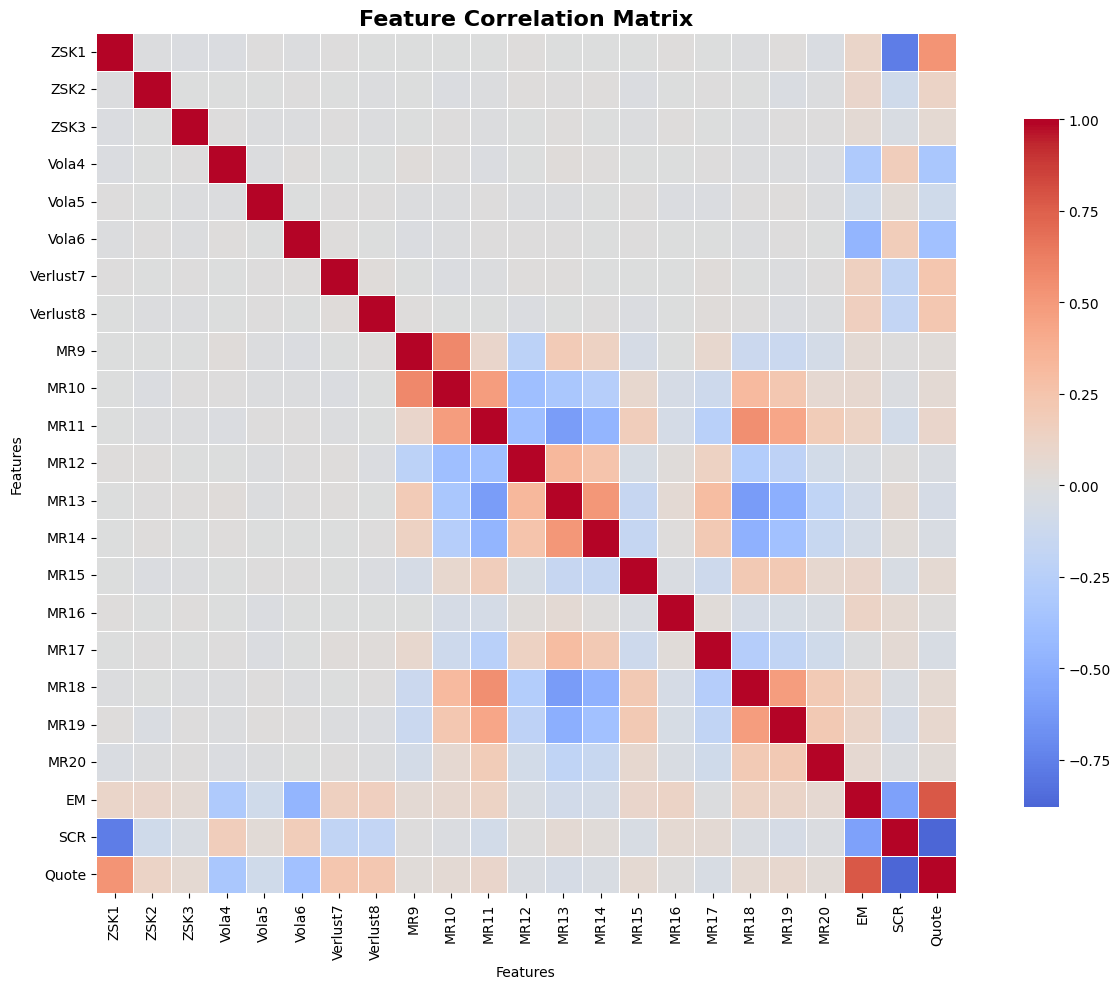

In [12]:
# Correlation matrix heatmap for all features
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

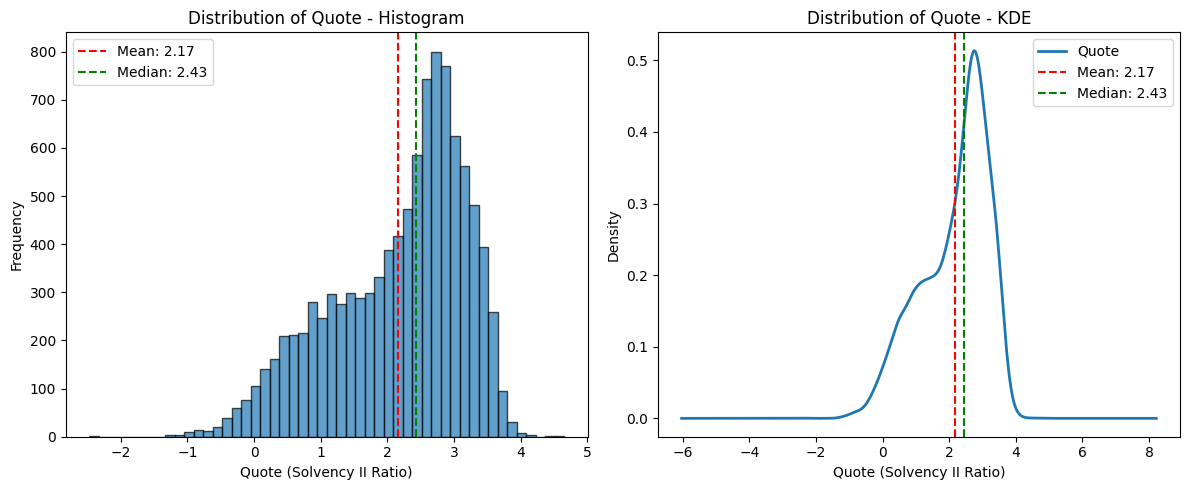

In [13]:
# Histogram/KDE of Quote
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['Quote'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Quote (Solvency II Ratio)')
plt.ylabel('Frequency')
plt.title('Distribution of Quote - Histogram')
plt.axvline(df['Quote'].mean(), color='red', linestyle='--', label=f'Mean: {df["Quote"].mean():.2f}')
plt.axvline(df['Quote'].median(), color='green', linestyle='--', label=f'Median: {df["Quote"].median():.2f}')
plt.legend()

plt.subplot(1, 2, 2)
df['Quote'].plot(kind='kde', linewidth=2)
plt.xlabel('Quote (Solvency II Ratio)')
plt.ylabel('Density')
plt.title('Distribution of Quote - KDE')
plt.axvline(df['Quote'].mean(), color='red', linestyle='--', label=f'Mean: {df["Quote"].mean():.2f}')
plt.axvline(df['Quote'].median(), color='green', linestyle='--', label=f'Median: {df["Quote"].median():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Statistical analysis of Quote 
print(f"\nQUOTE ANALYSIS:")
print(f"Mean: {df['Quote'].mean():.3f}, Std: {df['Quote'].std():.3f}")
print(f"Range: [{df['Quote'].min():.3f}, {df['Quote'].max():.3f}]")
print(f"Skewness: {stats.skew(df['Quote']):.3f}")
print(f"Kurtosis: {stats.kurtosis(df['Quote']):.3f}")
print(f"Observations with Quote < 1 (undercapitalized): {(df['Quote'] <= 1).sum()} ({(df['Quote'] <= 1).mean()*100:.1f}%)")
print(f"Observations with Quote > 2 (well-capitalized): {(df['Quote'] >= 2).sum()} ({(df['Quote'] >= 2).mean()*100:.1f}%)")


QUOTE ANALYSIS:
Mean: 2.166, Std: 1.005
Range: [-2.472, 4.653]
Skewness: -0.695
Kurtosis: -0.299
Observations with Quote < 1 (undercapitalized): 1654 (16.2%)
Observations with Quote > 2 (well-capitalized): 6499 (63.5%)


In [15]:
# Risk type groupings for features
risk_groups = {
    'Interest Rate': ['ZSK1', 'ZSK2', 'ZSK3'],
    'Market Volatility': ['Vola4', 'Vola5', 'Vola6'],
    'Market Losses': ['Verlust7', 'Verlust8'],
    'FI/RE Allocation': ['MR9', 'MR10', 'MR11', 'MR12', 'MR13', 'MR14'],
    'Other Mgmt Rules': ['MR15', 'MR16', 'MR17', 'MR18', 'MR19', 'MR20']
}

print(f"\nFEATURE GROUPS:")
for group_name, features in risk_groups.items():
    print(f"{group_name}: {', '.join(features)}")



FEATURE GROUPS:
Interest Rate: ZSK1, ZSK2, ZSK3
Market Volatility: Vola4, Vola5, Vola6
Market Losses: Verlust7, Verlust8
FI/RE Allocation: MR9, MR10, MR11, MR12, MR13, MR14
Other Mgmt Rules: MR15, MR16, MR17, MR18, MR19, MR20


In [16]:
# Outlier removal
original_size = len(df)
print(f"Original dataset size: {original_size}")

# Remove the most extreme 1% on each tail
quote_1st = df['Quote'].quantile(0.01)
quote_99th = df['Quote'].quantile(0.99)
em_1st = df['EM'].quantile(0.01)
em_99th = df['EM'].quantile(0.99)

print(f"Removing Quote < {quote_1st:.2f} or > {quote_99th:.2f}")
print(f"Removing EM < {em_1st:.2e} or > {em_99th:.2e}")

# Remove
extreme_outlier_mask = (
    (df['Quote'] >= quote_1st) & (df['Quote'] <= quote_99th) &
    (df['EM'] >= em_1st) & (df['EM'] <= em_99th)
)

df = df[extreme_outlier_mask].copy()
outliers_removed = original_size - len(df)

print(f"Extreme outliers removed: {outliers_removed} ({outliers_removed/original_size*100:.1f}%)")
print(f"Clean dataset size: {len(df)}")

Original dataset size: 10230
Removing Quote < -0.33 or > 3.69
Removing EM < -4.65e+08 or > 1.81e+09
Extreme outliers removed: 310 (3.0%)
Clean dataset size: 9920


In [17]:
# Target Normalization

df['Quote_original'] = df['Quote'].copy()
df['SCR_original'] = df['SCR'].copy()  
df['EM_original'] = df['EM'].copy()
print(f"Original scale ranges (BEFORE normalization):")
print(f"  Quote: [{df['Quote_original'].min():.3f}, {df['Quote_original'].max():.3f}]")
print(f"  SCR: [{df['SCR_original'].min():.2e}, {df['SCR_original'].max():.2e}]") 
print(f"  EM: [{df['EM_original'].min():.2e}, {df['EM_original'].max():.2e}]")

# Create target scalers (fit on full dataset before splitting)
quote_scaler = MinMaxScaler(feature_range=(-1, 1))
scr_scaler = MinMaxScaler(feature_range=(-1, 1))
em_scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalize targets
df['Quote'] = quote_scaler.fit_transform(df[['Quote']]).ravel()
df['SCR'] = scr_scaler.fit_transform(df[['SCR']]).ravel()
df['EM'] = em_scaler.fit_transform(df[['EM']]).ravel()

# Store scalers for later inverse transformation
target_scalers = {
    'quote': quote_scaler,
    'scr': scr_scaler,
    'em': em_scaler
}

print("\n")
print("NORMALIZATION VERIFICATION:")
print(f"Quote normalized range: [{df['Quote'].min():.3f}, {df['Quote'].max():.3f}]")
print(f"SCR normalized range: [{df['SCR'].min():.3f}, {df['SCR'].max():.3f}]")
print(f"EM normalized range: [{df['EM'].min():.3f}, {df['EM'].max():.3f}]")

print(f"\nQuote normalized std: {df['Quote'].std():.3f}")
print(f"SCR normalized std: {df['SCR'].std():.3f}")
print(f"EM normalized std: {df['EM'].std():.3f}")

# Check original scale ranges for comparison
print(f"\nORIGINAL SCALE RANGES:")
print(f"Quote original range: [{df['Quote_original'].min():.2e}, {df['Quote_original'].max():.2e}]")
print(f"SCR original range: [{df['SCR_original'].min():.2e}, {df['SCR_original'].max():.2e}]")
print(f"EM original range: [{df['EM_original'].min():.2e}, {df['EM_original'].max():.2e}]")

# Correlation check
print(f"\nCORRELATION ANALYSIS:")
print(f"SCR-EM correlation (normalized): {np.corrcoef(df['SCR'], df['EM'])[0,1]:.3f}")
print(f"SCR-EM correlation (original): {np.corrcoef(df['SCR_original'], df['EM_original'])[0,1]:.3f}")
print(f"Quote-SCR correlation: {np.corrcoef(df['Quote'], df['SCR'])[0,1]:.3f}")
print(f"Quote-EM correlation: {np.corrcoef(df['Quote'], df['EM'])[0,1]:.3f}")

Original scale ranges (BEFORE normalization):
  Quote: [-0.330, 3.686]
  SCR: [2.24e+08, 2.00e+09]
  EM: [-4.55e+08, 1.80e+09]


NORMALIZATION VERIFICATION:
Quote normalized range: [-1.000, 1.000]
SCR normalized range: [-1.000, 1.000]
EM normalized range: [-1.000, 1.000]

Quote normalized std: 0.477
SCR normalized std: 0.316
EM normalized std: 0.326

ORIGINAL SCALE RANGES:
Quote original range: [-3.30e-01, 3.69e+00]
SCR original range: [2.24e+08, 2.00e+09]
EM original range: [-4.55e+08, 1.80e+09]

CORRELATION ANALYSIS:
SCR-EM correlation (normalized): -0.532
SCR-EM correlation (original): -0.532
Quote-SCR correlation: -0.876
Quote-EM correlation: 0.767


In [18]:
# Create regulatory threshold indicators for enhanced analysis
df['regulatory_status'] = pd.cut(df['Quote_original'], 
                                bins=[-np.inf, 0, 1, 2, np.inf], 
                                labels=['Insolvent', 'Undercapitalized', 'Adequate', 'Well-Capitalized'])

df['is_insolvent'] = (df['Quote_original'] < 0).astype(int)
df['is_undercapitalized'] = (df['Quote_original'] < 1).astype(int)
df['is_well_capitalized'] = (df['Quote_original'] > 2).astype(int)

# Create distribution analysis plots for BOTH original and normalized versions
print(f"\nCreating target distribution analysis...")
os.makedirs("figs", exist_ok=True)

for target in ['Quote', 'EM', 'SCR']:
    # Original scale plots (using the _original columns)
    original_col = f'{target}_original'
    if original_col in df.columns:
        fig_orig = plot_distribution_analysis(df, original_col)
        fig_path_orig = os.path.join("figs", f"distribution_analysis_{target.lower()}_original.png")
        plt.savefig(fig_path_orig, dpi=300, bbox_inches='tight')
        # plt.show()
        plt.close(fig_orig)
    
    # Normalized scale plots (using the current columns)
    fig_norm = plot_distribution_analysis(df, target)
    fig_path_norm = os.path.join("figs", f"distribution_analysis_{target.lower()}_normalized.png")
    plt.savefig(fig_path_norm, dpi=300, bbox_inches='tight')
    # plt.show()
    plt.close(fig_norm)


Creating target distribution analysis...


# SECTION 2: Data preprocessing and splitting

In [19]:
# Set random seeds for reproducibility
RANDOM_STATE = 8
np.random.seed(RANDOM_STATE)

# Extract features and targets
X = df[feature_cols].copy()
y_quote = df['Quote'].copy()
y_scr = df['SCR'].copy()
y_em = df['EM'].copy()
y_multi = df[['SCR', 'EM']].copy()

print(f"Features shape: {X.shape}")
print(f"Primary target (Quote) shape: {y_quote.shape}")
print(f"Multi-target (SCR, EM) shape: {y_multi.shape}")

# Split data: Train (60%), Validation (20%), Test (20%)
X_temp, X_test, y_quote_temp, y_quote_test = train_test_split(
    X, y_quote, test_size=0.2, random_state=RANDOM_STATE
)

X_train, X_val, y_quote_train, y_quote_val = train_test_split(
    X_temp, y_quote_temp, test_size=0.25, random_state=RANDOM_STATE
)

# Split other targets accordingly
_, y_scr_test = train_test_split(y_scr, test_size=0.2, random_state=RANDOM_STATE)
_, y_em_test = train_test_split(y_em, test_size=0.2, random_state=RANDOM_STATE)
_, y_multi_test = train_test_split(y_multi, test_size=0.2, random_state=RANDOM_STATE)

y_scr_temp, _ = train_test_split(y_scr, test_size=0.2, random_state=RANDOM_STATE)
y_em_temp, _ = train_test_split(y_em, test_size=0.2, random_state=RANDOM_STATE)
y_multi_temp, _ = train_test_split(y_multi, test_size=0.2, random_state=RANDOM_STATE)

y_scr_train, y_scr_val = train_test_split(y_scr_temp, test_size=0.25, random_state=RANDOM_STATE)
y_em_train, y_em_val = train_test_split(y_em_temp, test_size=0.25, random_state=RANDOM_STATE)
y_multi_train, y_multi_val = train_test_split(y_multi_temp, test_size=0.25, random_state=RANDOM_STATE)

print(f"\nData splits:")
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(df)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")

# Create preprocessing pipeline (fit only on training data) + standarize
numeric_features = feature_cols
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features)
])

print(f"\nPreprocessing pipeline created with {len(numeric_features)} numeric features")

Features shape: (9920, 20)
Primary target (Quote) shape: (9920,)
Multi-target (SCR, EM) shape: (9920, 2)

Data splits:
Train: 5952 samples (60.0%)
Validation: 1984 samples (20.0%)
Test: 1984 samples (20.0%)

Preprocessing pipeline created with 20 numeric features


# SECTION 3: Models

## SECTION 3.1: Model Definitions

In [20]:
# Models with different complexity levels and loss functions
models_config = {
    'dummy': {
        'name': 'Dummy Regressor',
        'model': DummyRegressor(strategy='mean'),
        'loss': 'MSE'
    },
    'linear_mse': {
        'name': 'Linear Regression (MSE)',
        'model': LinearRegression(),
        'loss': 'MSE'
    },
    'linear_mae': {
        'name': 'Linear Regression (MAE)',
        'model': LinearRegression(),  # sklearn LinearRegression always uses MSE
        'loss': 'MAE'
    },
    # 'quadratic': {
    #     'name': 'Quadratic (Degree 2)',
    #     'model': Pipeline([
    #         ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    #         ('ridge', Ridge(alpha=1.0, random_state=RANDOM_STATE))
    #     ]),
    #     'loss': 'MSE'
    # },
    # 'cubic': {
    #     'name': 'Cubic (Degree 3)',
    #     'model': Pipeline([
    #         ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    #         ('ridge', Ridge(alpha=10.0, random_state=RANDOM_STATE))
    #     ]),
    #     'loss': 'MSE'
    # },
    'quadratic': {
    'name': 'Quadratic (Degree 2)',
    'model': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('ridge', Ridge(alpha=100.0, random_state=RANDOM_STATE))  
    ]),
    'loss': 'MSE'
    },
    'cubic': {
        'name': 'Cubic (Degree 3)', 
        'model': Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('ridge', Ridge(alpha=1000.0, random_state=RANDOM_STATE))
        ]),
        'loss': 'MSE'
    },
    # 'elastic_net': {
    #     'name': 'Elastic Net',
    #     'model': ElasticNet(random_state=RANDOM_STATE),
    #     'loss': 'MSE',
    #     'param_grid': {
    #         'alpha': [0.01, 0.1, 1.0, 10.0],
    #         'l1_ratio': [0.1, 0.5, 0.7, 0.9]
    #     }
    # }
    'elastic_net': {
    'name': 'Elastic Net',
    'model': ElasticNet(random_state=RANDOM_STATE),
    'loss': 'MSE',
    'param_grid': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Wider range
        'l1_ratio': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99]  # More options
        }
    },
    'ridge_cv': {
        'name': 'Ridge with CV',
        'model': RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5),
        'loss': 'MSE'
    },
    'lasso_cv': {
        'name': 'Lasso with CV', 
        'model': LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, random_state=RANDOM_STATE),
        'loss': 'MSE'
    }
}

print(f"Defined {len(models_config)} model configurations:")
for key, config in models_config.items():
    print(f"  - {config['name']} (Loss: {config['loss']})")


Defined 8 model configurations:
  - Dummy Regressor (Loss: MSE)
  - Linear Regression (MSE) (Loss: MSE)
  - Linear Regression (MAE) (Loss: MAE)
  - Quadratic (Degree 2) (Loss: MSE)
  - Cubic (Degree 3) (Loss: MSE)
  - Elastic Net (Loss: MSE)
  - Ridge with CV (Loss: MSE)
  - Lasso with CV (Loss: MSE)


## SECTION 3.2: Model Training & Eval Functions

In [21]:
def train_and_evaluate_model(model_config, X_train, X_val, X_test, y_train, y_val, y_test, 
                                  preprocessor, target_name, cv_folds=5):
    """Train and evaluate a single model with comprehensive metrics"""
    
    model_name = model_config['name']
    base_model = copy.deepcopy(model_config['model'])
    
    print(f"\nTraining {model_name} for {target_name}...")
    
    # Create pipeline
    if 'param_grid' in model_config:
        pipeline = Pipeline([
            ('preprocessor', copy.deepcopy(preprocessor)), 
            ('model', base_model)
        ])
        
        param_grid = {f'model__{k}': v for k, v in model_config['param_grid'].items()}
        
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv_folds, 
            scoring='neg_mean_squared_error', n_jobs=-1
        )
        
        grid_search.fit(X_train, y_train)
        final_model = grid_search.best_estimator_
        print(f"  Best parameters: {grid_search.best_params_}")
        
    else:
        final_model = Pipeline([
            ('preprocessor', copy.deepcopy(preprocessor)),  
            ('model', base_model) 
        ])
        final_model.fit(X_train, y_train)
    
    # Cross-validation and predictions
    cv_scores = cross_val_score(final_model, X_train, y_train,
                               cv=cv_folds, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    y_train_pred = final_model.predict(X_train)
    y_val_pred = final_model.predict(X_val)
    y_test_pred = final_model.predict(X_test)
    
    # Calculate normalized metrics (for fair comparison)
    train_metrics_norm = calculate_all_metrics(y_train, y_train_pred, "train_norm_")
    val_metrics_norm = calculate_all_metrics(y_val, y_val_pred, "val_norm_")
    test_metrics_norm = calculate_all_metrics(y_test, y_test_pred, "test_norm_")
    
    all_metrics = {
        **train_metrics_norm, 
        **val_metrics_norm, 
        **test_metrics_norm,
        'cv_rmse_mean': cv_rmse.mean(),
        'cv_rmse_std': cv_rmse.std()
    }
    
    # Convert to original scale for business interpretation
    if target_name in ['Quote', 'SCR', 'EM']:
        scaler_key = target_name.lower()
        if scaler_key in target_scalers:
            target_scaler = target_scalers[scaler_key]
            
            # Convert predictions to original scale
            y_train_pred_orig = target_scaler.inverse_transform(np.array(y_train_pred).reshape(-1, 1)).ravel()
            y_val_pred_orig = target_scaler.inverse_transform(np.array(y_val_pred).reshape(-1, 1)).ravel()
            y_test_pred_orig = target_scaler.inverse_transform(np.array(y_test_pred).reshape(-1, 1)).ravel()

            y_train_orig = target_scaler.inverse_transform(np.array(y_train).reshape(-1, 1)).ravel()
            y_val_orig = target_scaler.inverse_transform(np.array(y_val).reshape(-1, 1)).ravel()
            y_test_orig = target_scaler.inverse_transform(np.array(y_test).reshape(-1, 1)).ravel()
            
            # Calculate original scale metrics
            train_metrics_orig = calculate_all_metrics(y_train_orig, y_train_pred_orig, "train_orig_")
            val_metrics_orig = calculate_all_metrics(y_val_orig, y_val_pred_orig, "val_orig_")
            test_metrics_orig = calculate_all_metrics(y_test_orig, y_test_pred_orig, "test_orig_")
            
            all_metrics.update({**train_metrics_orig, **val_metrics_orig, **test_metrics_orig})
            
            # Regulatory analysis for Quote
            if target_name == 'Quote':
                print(f"\n  Regulatory Performance Analysis for {model_name}:")
                val_reg_results = analyze_regulatory_performance(y_val_orig, y_val_pred_orig, f"{model_name} - Validation")
                test_reg_results = analyze_regulatory_performance(y_test_orig, y_test_pred_orig, f"{model_name} - Test")
                
                all_metrics['regulatory_val'] = val_reg_results
                all_metrics['regulatory_test'] = test_reg_results
                
                results_predictions = {
                    'train': y_train_pred_orig,
                    'val': y_val_pred_orig,
                    'test': y_test_pred_orig,
                    'train_norm': y_train_pred,
                    'val_norm': y_val_pred,
                    'test_norm': y_test_pred
                }
                
                results_actuals = {
                    'train': y_train_orig,
                    'val': y_val_orig,
                    'test': y_test_orig,
                    'train_norm': y_train,
                    'val_norm': y_val,
                    'test_norm': y_test
                }
            else:
                results_predictions = {
                    'train': y_train_pred_orig,
                    'val': y_val_pred_orig,
                    'test': y_test_pred_orig,
                    'train_norm': y_train_pred,
                    'val_norm': y_val_pred,
                    'test_norm': y_test_pred
                }
                
                results_actuals = {
                    'train': y_train_orig,
                    'val': y_val_orig,
                    'test': y_test_orig,
                    'train_norm': y_train,
                    'val_norm': y_val,
                    'test_norm': y_test
                }
        else:
            # Fallback
            results_predictions = {
                'train': y_train_pred,
                'val': y_val_pred,
                'test': y_test_pred
            }
            
            results_actuals = {
                'train': y_train,
                'val': y_val,
                'test': y_test
            }
    else:
        results_predictions = {
            'train': y_train_pred,
            'val': y_val_pred,
            'test': y_test_pred
        }
        
        results_actuals = {
            'train': y_train,
            'val': y_val,
            'test': y_test
        }
    
    results = {
        'model': final_model,
        'model_name': model_name,
        'target_name': target_name,
        'metrics': all_metrics,
        'predictions': results_predictions,
        'actuals': results_actuals
    }
    
    return results

def train_multioutput_model_consolidated(model_config, X_train, X_val, X_test, y_train, y_val, y_test, 
                                       preprocessor, cv_folds=5, calculate_quote=True):
    """
    Consolidated multi-output training for SCR and EM with optional Quote calculation
    
    Args:
        calculate_quote (bool): If True, calculates Quote = EM/SCR from joint predictions
                               If False, only reports SCR and EM metrics (original behavior)
    """
    
    model_name = model_config['name']
    base_model = copy.deepcopy(model_config['model'])
    
    print(f"\nTraining {model_name} (Multi-Output)...")
    
    try:
        # Create multi-output pipeline
        if isinstance(base_model, (RandomForestRegressor, GradientBoostingRegressor)):
            # Tree-based models support multi-output natively
            final_model = Pipeline([
                ('preprocessor', copy.deepcopy(preprocessor)),
                ('model', base_model)
            ])
        else:
            # Other models need MultiOutputRegressor wrapper
            multi_model = MultiOutputRegressor(base_model)
            final_model = Pipeline([
                ('preprocessor', copy.deepcopy(preprocessor)),
                ('model', multi_model)
            ])
        
        final_model.fit(X_train, y_train)
        
        # Predictions for EM and SCR (NORMALIZED SCALE)
        y_train_pred = final_model.predict(X_train)  # Shape: (n_samples, 2) [SCR, EM]
        y_val_pred = final_model.predict(X_val)
        y_test_pred = final_model.predict(X_test)
        
        # Calculate metrics for SCR and EM (normalized scale for consistency)
        all_metrics = {}
        target_names = ['SCR', 'EM']
        
        for i, target in enumerate(target_names):
            train_metrics = calculate_all_metrics(y_train.iloc[:, i], y_train_pred[:, i], f"train_{target}_")
            val_metrics = calculate_all_metrics(y_val.iloc[:, i], y_val_pred[:, i], f"val_{target}_")
            test_metrics = calculate_all_metrics(y_test.iloc[:, i], y_test_pred[:, i], f"test_{target}_")
            
            all_metrics.update({**train_metrics, **val_metrics, **test_metrics})
        
        # Calculate macro-averaged metrics for SCR+EM
        train_rmse_macro = np.mean([all_metrics[f'train_{t}_RMSE'] for t in target_names])
        val_rmse_macro = np.mean([all_metrics[f'val_{t}_RMSE'] for t in target_names])
        test_rmse_macro = np.mean([all_metrics[f'test_{t}_RMSE'] for t in target_names])
        
        all_metrics.update({
            'train_RMSE_macro': train_rmse_macro,
            'val_RMSE_macro': val_rmse_macro,
            'test_RMSE_macro': test_rmse_macro
        })
        
        # OPTIONAL: Calculate Quote from EM/SCR predictions (your email hypothesis)
        if calculate_quote:
            # Convert predictions to ORIGINAL scale for proper Quote calculation
            if 'scr' in target_scalers and 'em' in target_scalers and 'quote' in target_scalers:
                scr_scaler = target_scalers['scr']
                em_scaler = target_scalers['em']
                quote_scaler = target_scalers['quote']
                
                # Extract normalized predictions
                scr_train_pred_norm = y_train_pred[:, 0]
                em_train_pred_norm = y_train_pred[:, 1]
                scr_val_pred_norm = y_val_pred[:, 0]
                em_val_pred_norm = y_val_pred[:, 1]
                scr_test_pred_norm = y_test_pred[:, 0]
                em_test_pred_norm = y_test_pred[:, 1]
                
                # Convert to original scale
                scr_train_pred_orig = scr_scaler.inverse_transform(scr_train_pred_norm.reshape(-1, 1)).ravel()
                em_train_pred_orig = em_scaler.inverse_transform(em_train_pred_norm.reshape(-1, 1)).ravel()
                scr_val_pred_orig = scr_scaler.inverse_transform(scr_val_pred_norm.reshape(-1, 1)).ravel()
                em_val_pred_orig = em_scaler.inverse_transform(em_val_pred_norm.reshape(-1, 1)).ravel()
                scr_test_pred_orig = scr_scaler.inverse_transform(scr_test_pred_norm.reshape(-1, 1)).ravel()
                em_test_pred_orig = em_scaler.inverse_transform(em_test_pred_norm.reshape(-1, 1)).ravel()
                
                # Calculate Quote in ORIGINAL scale (proper division)
                quote_train_pred_orig = np.where(np.abs(scr_train_pred_orig) > 1e-6, 
                                               em_train_pred_orig / scr_train_pred_orig, 0)
                quote_val_pred_orig = np.where(np.abs(scr_val_pred_orig) > 1e-6, 
                                             em_val_pred_orig / scr_val_pred_orig, 0)
                quote_test_pred_orig = np.where(np.abs(scr_test_pred_orig) > 1e-6, 
                                              em_test_pred_orig / scr_test_pred_orig, 0)
                
                # Convert calculated Quote back to normalized scale for fair comparison
                quote_train_pred_norm = quote_scaler.transform(quote_train_pred_orig.reshape(-1, 1)).ravel()
                quote_val_pred_norm = quote_scaler.transform(quote_val_pred_orig.reshape(-1, 1)).ravel()
                quote_test_pred_norm = quote_scaler.transform(quote_test_pred_orig.reshape(-1, 1)).ravel()
                
                # Get actual Quote values (assuming y_quote_train, etc. are available)
                try:
                    quote_train_actual_norm = np.array(y_quote_train)
                    quote_val_actual_norm = np.array(y_quote_val)
                    quote_test_actual_norm = np.array(y_quote_test)
                    
                    # Calculate Quote metrics (NORMALIZED scale for fair comparison)
                    quote_train_metrics = calculate_all_metrics(quote_train_actual_norm, quote_train_pred_norm, "train_Quote_")
                    quote_val_metrics = calculate_all_metrics(quote_val_actual_norm, quote_val_pred_norm, "val_Quote_")
                    quote_test_metrics = calculate_all_metrics(quote_test_actual_norm, quote_test_pred_norm, "test_Quote_")
                    
                    all_metrics.update({**quote_train_metrics, **quote_val_metrics, **quote_test_metrics})
                    
                    print(f"    Quote calculation successful:")
                    print(f"    Quote Val RMSE (norm): {all_metrics['val_Quote_RMSE']:.4f}")
                    print(f"    Quote Test RMSE (norm): {all_metrics['test_Quote_RMSE']:.4f}")
                    print(f"    Quote Test R² (norm): {all_metrics['test_Quote_R2']:.4f}")
                    
                except NameError:
                    print(f"  ⚠️ Quote target variables not available, skipping Quote calculation")
                    calculate_quote = False
            else:
                print(f"  ⚠️ Scalers not available, skipping Quote calculation")
                calculate_quote = False
        
        # Print performance summary
        print(f"    Success! Model Performance:")
        print(f"    SCR Val RMSE: {all_metrics['val_SCR_RMSE']:.4f}")
        print(f"    EM Val RMSE: {all_metrics['val_EM_RMSE']:.4f}")
        print(f"    Combined Val RMSE: {val_rmse_macro:.4f}")
        
        # Prepare results
        target_name = 'Joint_SCR_EM_Quote' if calculate_quote else 'SCR_EM_Multi'
        
        results = {
            'model': final_model,
            'model_name': model_name + (' (with Quote)' if calculate_quote else ' (Multi-Output)'),
            'target_name': target_name,
            'metrics': all_metrics,
            'predictions': {
                'train': y_train_pred,
                'val': y_val_pred,
                'test': y_test_pred
            },
            'actuals': {
                'train': y_train,
                'val': y_val,
                'test': y_test
            },
            'quote_calculated': calculate_quote
        }
        
        return results
        
    except Exception as e:
        print(f"  ❌ Error: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


In [22]:
all_results = {}

# Train models for Quote (primary target)
print("\nTRAINING MODELS FOR QUOTE (PRIMARY TARGET)")
all_results['quote'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_and_evaluate_model(
            model_config, X_train, X_val, X_test, 
            y_quote_train, y_quote_val, y_quote_test,
            preprocessor, "Quote"
        )
        all_results['quote'][model_key] = results
        
        # Print summary metrics
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    CV RMSE: {metrics['cv_rmse_mean']:.4f} (±{metrics['cv_rmse_std']:.4f})")
        print(f"    Val RMSE (Norm): {metrics['val_norm_RMSE']:.4f}")
        print(f"    Val RMSE (Orig): {metrics['val_orig_RMSE']:.2e}")
        print(f"    Test RMSE (Norm): {metrics['test_norm_RMSE']:.4f}")
        print(f"    Test RMSE (Orig): {metrics['test_orig_RMSE']:.2e}")
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

# Train models for SCR (secondary target)
print("\nTRAINING MODELS FOR SCR (SECONDARY TARGET)")
all_results['scr'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_and_evaluate_model(
            model_config, X_train, X_val, X_test,
            y_scr_train, y_scr_val, y_scr_test,
            preprocessor, "SCR"
        )
        all_results['scr'][model_key] = results
        
        # Print summary metrics 
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    CV RMSE: {metrics['cv_rmse_mean']:.4f} (±{metrics['cv_rmse_std']:.4f})")
        print(f"    Val RMSE (Norm): {metrics['val_norm_RMSE']:.4f}")
        print(f"    Val RMSE (Orig): {metrics['val_orig_RMSE']:.2e}")
        print(f"    Test RMSE (Norm): {metrics['test_norm_RMSE']:.4f}")
        print(f"    Test RMSE (Orig): {metrics['test_orig_RMSE']:.2e}")
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

# Train models for EM (secondary target)
print("\nTRAINING MODELS FOR EM (SECONDARY TARGET)")
all_results['em'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_and_evaluate_model(
            model_config, X_train, X_val, X_test,
            y_em_train, y_em_val, y_em_test,
            preprocessor, "EM"
        )
        all_results['em'][model_key] = results
        
        # Print summary metrics
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    CV RMSE: {metrics['cv_rmse_mean']:.4f} (±{metrics['cv_rmse_std']:.4f})")
        print(f"    Val RMSE (Norm): {metrics['val_norm_RMSE']:.4f}")
        print(f"    Val RMSE (Orig): {metrics['val_orig_RMSE']:.2e}")
        print(f"    Test RMSE (Norm): {metrics['test_norm_RMSE']:.4f}")
        print(f"    Test RMSE (Orig): {metrics['test_orig_RMSE']:.2e}")
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

# Train multi-output models for SCR and EM
print("\nTRAINING MULTI-OUTPUT MODELS FOR SCR & EM")
all_results['multi_output'] = {}

for model_key, model_config in models_config.items():
    try:
        results = train_multioutput_model_consolidated(
            model_config, X_train, X_val, X_test,
            y_multi_train, y_multi_val, y_multi_test,
            preprocessor,  calculate_quote=False
        )
        all_results['multi_output'][model_key] = results
        
        # Multi-output metrics
        metrics = results['metrics']
        print(f"  {results['model_name']}:")
        print(f"    Val RMSE (SCR): {metrics['val_SCR_RMSE']:.4f}")
        print(f"    Val RMSE (EM): {metrics['val_EM_RMSE']:.4f}")
        print(f"    Val RMSE (Macro): {metrics['val_RMSE_macro']:.4f}")
        
    except Exception as e:
        print(f"  Error training multi-output {model_config['name']}: {str(e)}")


TRAINING MODELS FOR QUOTE (PRIMARY TARGET)

Training Dummy Regressor for Quote...

  Regulatory Performance Analysis for Dummy Regressor:

REGULATORY PERFORMANCE ANALYSIS - Dummy Regressor - Validation

Insolvent (31 obs, 1.6%):
  RMSE: 2.2979
  MAE: 2.2962
  R²: -675.2959

Undercapitalized (272 obs, 13.7%):
  RMSE: 1.6189
  MAE: 1.5939
  R²: -31.6452

Adequate (409 obs, 20.6%):
  RMSE: 0.6889
  MAE: 0.6287
  R²: -4.9785

Well-Capitalized (1272 obs, 64.1%):
  RMSE: 0.7510
  MAE: 0.6352
  R²: -2.2650

REGULATORY PERFORMANCE ANALYSIS - Dummy Regressor - Test

Insolvent (32 obs, 1.6%):
  RMSE: 2.3183
  MAE: 2.3166
  R²: -656.0796

Undercapitalized (261 obs, 13.2%):
  RMSE: 1.5881
  MAE: 1.5640
  R²: -32.1114

Adequate (413 obs, 20.8%):
  RMSE: 0.6986
  MAE: 0.6339
  R²: -4.6556

Well-Capitalized (1278 obs, 64.4%):
  RMSE: 0.7793
  MAE: 0.6699
  R²: -2.5448
  Dummy Regressor:
    CV RMSE: 0.4790 (±0.0055)
    Val RMSE (Norm): 0.4728
    Val RMSE (Orig): 9.49e-01
    Test RMSE (Norm): 0.47

In [23]:
# Enhanced multi-output models configuration
enhanced_models_config = {
    'linear_multi': {
        'name': 'Linear Regression (Multi-Output)',
        'model': LinearRegression(),
        'loss': 'MSE'
    },
    'ridge_multi': {
        'name': 'Ridge Regression (Multi-Output)', 
        'model': RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0, 1000.0], cv=5),
        'loss': 'MSE'
    },
    'poly2_multi': {
        'name': 'Quadratic (Multi-Output)',
        'model': Pipeline([
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('ridge', Ridge(alpha=100.0, random_state=RANDOM_STATE))
        ]),
        'loss': 'MSE'
    },
    'random_forest_multi': {
        'name': 'Random Forest (Multi-Output)',
        'model': RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1),
        'loss': 'MSE'
    }
}

# Train enhanced multi-output models
enhanced_results = {}

for model_key, model_config in enhanced_models_config.items():
    try:
        results = train_multioutput_model_consolidated(
            model_config, X_train, X_val, X_test,
            y_multi_train, y_multi_val, y_multi_test,  # [SCR, EM] targets (normalized)
            preprocessor, calculate_quote=True
        )
        if results is not None:
            enhanced_results[model_key] = results
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")


print(f"\nDEBUG: Successfully trained {len(enhanced_results)} models")
for key, result in enhanced_results.items():
    if result is not None:
        print(f"  {key}: {result['model_name']}")
        # Check if Quote metrics exist
        quote_rmse = result['metrics'].get('val_Quote_RMSE', 'MISSING')
        print(f"    Quote Val RMSE: {quote_rmse}")

def create_joint_model_comparison(results_dict):
    """Create comparison table for joint EM-SCR models with calculated Quote"""
    comparison_data = []
    
    for model_key, results in results_dict.items():
        if results is None:
            continue
            
        metrics = results['metrics']
        row = {
            'Model': results['model_name'],
            'SCR_Val_RMSE': metrics.get('val_SCR_RMSE', np.nan),
            'EM_Val_RMSE': metrics.get('val_EM_RMSE', np.nan),
            'Quote_Val_RMSE': metrics.get('val_Quote_RMSE', np.nan),  # Calculated Quote
            'Quote_Test_RMSE': metrics.get('test_Quote_RMSE', np.nan),  # Calculated Quote
            'Quote_Test_R2': metrics.get('test_Quote_R2', np.nan)
        }
        comparison_data.append(row)
    
    if not comparison_data:
        print(" No successful models to compare!")
        return pd.DataFrame()
    
    df_comparison = pd.DataFrame(comparison_data)
    
    # Check if Quote_Val_RMSE column exists before sorting
    if 'Quote_Val_RMSE' in df_comparison.columns and not df_comparison['Quote_Val_RMSE'].isna().all():
        df_comparison = df_comparison.sort_values('Quote_Val_RMSE')
    else:
        print(" Warning: Quote_Val_RMSE not available, sorting by Model name")
        df_comparison = df_comparison.sort_values('Model')
    
    print(f"\nJOINT MODELING RESULTS (EM-SCR → Quote)")
    print("="*100)
    print("NOTE: Quote values are CALCULATED from EM/SCR predictions (Quote = EM/SCR)")
    print("="*100)
    print(df_comparison.round(4).to_string(index=False))
    
    return df_comparison

# Create comparison table
joint_comparison = create_joint_model_comparison(enhanced_results)

# Find best joint model
best_joint_model = None
best_quote_rmse = float('inf')

for model_key, results in enhanced_results.items():
    if results is not None:
        quote_rmse = results['metrics'].get('val_Quote_RMSE', float('inf'))
        if quote_rmse < best_quote_rmse:
            best_quote_rmse = quote_rmse
            best_joint_model = results

if best_joint_model:
    print(f"\n BEST JOINT MODEL:")
    print(f"Model: {best_joint_model['model_name']}")
    print(f"Quote Val RMSE (calculated): {best_quote_rmse:.4f}")
    print(f"Quote Test RMSE (calculated): {best_joint_model['metrics']['test_Quote_RMSE']:.4f}")
    print(f"Quote Test R²: {best_joint_model['metrics']['test_Quote_R2']:.4f}")

    best_models = {}
    # Find best Quote model from all_results
    best_quote_rmse_norm = float('inf')
    for model_key, results in all_results['quote'].items():
        if results is not None:
            val_rmse = results['metrics'].get('val_norm_RMSE', float('inf'))
            if val_rmse < best_quote_rmse_norm:
                best_quote_rmse_norm = val_rmse
                best_models['quote'] = {
                    'results': results,
                    'val_rmse_norm': val_rmse
                }
    # Compare with direct Quote prediction
    if 'quote' in best_models:
        direct_quote_rmse = best_models['quote']['val_rmse_norm']
        joint_quote_rmse = best_quote_rmse
        
        print(f"\n APPROACH COMPARISON:")
        print(f"Direct Quote Prediction RMSE: {direct_quote_rmse:.4f}")
        print(f"Joint EM-SCR → Quote RMSE: {joint_quote_rmse:.4f}")
        
        if joint_quote_rmse < direct_quote_rmse:
            improvement = ((direct_quote_rmse - joint_quote_rmse) / direct_quote_rmse) * 100
            print(f" Joint approach is BETTER by {improvement:.1f}%")
        else:
            degradation = ((joint_quote_rmse - direct_quote_rmse) / direct_quote_rmse) * 100
            print(f" Joint approach is worse by {degradation:.1f}%")
            
        # Correlation analysis
        print(f"\n CORRELATION ANALYSIS:")
        scr_em_corr = np.corrcoef(y_multi_train.iloc[:, 0], y_multi_train.iloc[:, 1])[0, 1]
        print(f"SCR-EM correlation: {scr_em_corr:.3f}")
        
else:
    print("\n No joint models trained successfully!")


Training Linear Regression (Multi-Output) (Multi-Output)...
    Quote calculation successful:
    Quote Val RMSE (norm): 3.9878
    Quote Test RMSE (norm): 1.7529
    Quote Test R² (norm): -12.6336
    Success! Model Performance:
    SCR Val RMSE: 0.1609
    EM Val RMSE: 0.2553
    Combined Val RMSE: 0.2081

Training Ridge Regression (Multi-Output) (Multi-Output)...
    Quote calculation successful:
    Quote Val RMSE (norm): 4.9405
    Quote Test RMSE (norm): 1.6762
    Quote Test R² (norm): -11.4674
    Success! Model Performance:
    SCR Val RMSE: 0.1609
    EM Val RMSE: 0.2553
    Combined Val RMSE: 0.2081

Training Quadratic (Multi-Output) (Multi-Output)...
    Quote calculation successful:
    Quote Val RMSE (norm): 0.1966
    Quote Test RMSE (norm): 0.2386
    Quote Test R² (norm): 0.7473
    Success! Model Performance:
    SCR Val RMSE: 0.0908
    EM Val RMSE: 0.1089
    Combined Val RMSE: 0.0998

Training Random Forest (Multi-Output) (Multi-Output)...
    Quote calculation su

In [24]:
enhanced_results_fixed = {}

for model_key, model_config in enhanced_models_config.items():
    try:
        results = train_multioutput_model_consolidated(
            model_config, X_train, X_val, X_test,
            y_multi_train, y_multi_val, y_multi_test,  # [SCR, EM] targets (normalized)
            preprocessor, calculate_quote=True
        )
        if results is not None:
            enhanced_results_fixed[model_key] = results
        
    except Exception as e:
        print(f"  Error training {model_config['name']}: {str(e)}")

def create_fixed_joint_comparison(results_dict):
    """Create comparison table for FIXED joint EM-SCR models"""
    comparison_data = []
    
    for model_key, results in results_dict.items():
        if results is None:
            continue
            
        metrics = results['metrics']
        row = {
            'Model': results['model_name'],
            'SCR_Val_RMSE': metrics.get('val_SCR_RMSE', np.nan),
            'EM_Val_RMSE': metrics.get('val_EM_RMSE', np.nan),
            'Quote_Val_RMSE_Norm': metrics.get('val_Quote_RMSE', np.nan),  # Normalized for comparison
            'Quote_Test_RMSE_Norm': metrics.get('test_Quote_RMSE', np.nan),
            'Quote_Test_R2_Norm': metrics.get('test_Quote_R2', np.nan),
            'Quote_Test_RMSE_Orig': metrics.get('test_Quote_orig_RMSE', np.nan),  # Original for business
            'Quote_Test_R2_Orig': metrics.get('test_Quote_orig_R2', np.nan)
        }
        comparison_data.append(row)
    
    if not comparison_data:
        print(" No successful models to compare!")
        return pd.DataFrame()
    
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('Quote_Val_RMSE_Norm')
    

    print("="*120)
    print("NOTE: Quote calculated in ORIGINAL scale then normalized for fair comparison")
    print("="*120)
    print(df_comparison.round(4).to_string(index=False))
    
    return df_comparison

# Create comparison table
joint_comparison_fixed = create_fixed_joint_comparison(enhanced_results_fixed)

# Find best joint model
best_joint_model_fixed = None
best_quote_rmse_fixed = float('inf')

for model_key, results in enhanced_results_fixed.items():
    if results is not None:
        quote_rmse = results['metrics'].get('val_Quote_RMSE', float('inf'))
        if quote_rmse < best_quote_rmse_fixed:
            best_quote_rmse_fixed = quote_rmse
            best_joint_model_fixed = results

if best_joint_model_fixed:
    print(f"\n BEST FIXED JOINT MODEL:")
    print(f"Model: {best_joint_model_fixed['model_name']}")
    print(f"Quote Val RMSE (normalized): {best_quote_rmse_fixed:.4f}")
    print(f"Quote Test RMSE (normalized): {best_joint_model_fixed['metrics']['test_Quote_RMSE']:.4f}")
    print(f"Quote Test R² (normalized): {best_joint_model_fixed['metrics']['test_Quote_R2']:.4f}")
    
    # Compare with direct Quote prediction
    if 'quote' in best_models:
        direct_quote_rmse = best_models['quote']['val_rmse_norm']
        joint_quote_rmse_fixed = best_quote_rmse_fixed
        
        print(f"\n FIXED APPROACH COMPARISON:")
        print(f"Direct Quote Prediction RMSE: {direct_quote_rmse:.4f}")
        print(f"Fixed Joint EM-SCR → Quote RMSE: {joint_quote_rmse_fixed:.4f}")
        
        if joint_quote_rmse_fixed < direct_quote_rmse:
            improvement = ((direct_quote_rmse - joint_quote_rmse_fixed) / direct_quote_rmse) * 100
            print(f" Fixed joint approach is BETTER by {improvement:.1f}%")
        else:
            degradation = ((joint_quote_rmse_fixed - direct_quote_rmse) / direct_quote_rmse) * 100
            print(f" Fixed joint approach is still worse by {degradation:.1f}%")
            
        # Analysis
        print(f"\n ANALYSIS:")
        scr_em_corr = np.corrcoef(y_multi_train.iloc[:, 0], y_multi_train.iloc[:, 1])[0, 1]
        print(f"SCR-EM correlation: {scr_em_corr:.3f}")
        
        if joint_quote_rmse_fixed > direct_quote_rmse:
            print(f"\n WHY JOINT MODELING MAY NOT HELP:")
            print(f"1. Negative correlation (-0.54) makes joint learning harder")
            print(f"2. Division amplifies small prediction errors")
            print(f"3. Quote relationship may be better learned directly")
            print(f"4. Recommendation: Use direct Quote prediction approach")
        else:
            print(f"\n WHY JOINT MODELING HELPS:")
            print(f"1. Captures shared dependencies (ZSK1-ZSK3)")
            print(f"2. Preserves EM/SCR mathematical relationship")
            print(f"3. Recommendation: Use joint approach")
        
else:
    print("\n No fixed joint models trained successfully!")



Training Linear Regression (Multi-Output) (Multi-Output)...
    Quote calculation successful:
    Quote Val RMSE (norm): 3.9878
    Quote Test RMSE (norm): 1.7529
    Quote Test R² (norm): -12.6336
    Success! Model Performance:
    SCR Val RMSE: 0.1609
    EM Val RMSE: 0.2553
    Combined Val RMSE: 0.2081

Training Ridge Regression (Multi-Output) (Multi-Output)...
    Quote calculation successful:
    Quote Val RMSE (norm): 4.9405
    Quote Test RMSE (norm): 1.6762
    Quote Test R² (norm): -11.4674
    Success! Model Performance:
    SCR Val RMSE: 0.1609
    EM Val RMSE: 0.2553
    Combined Val RMSE: 0.2081

Training Quadratic (Multi-Output) (Multi-Output)...
    Quote calculation successful:
    Quote Val RMSE (norm): 0.1966
    Quote Test RMSE (norm): 0.2386
    Quote Test R² (norm): 0.7473
    Success! Model Performance:
    SCR Val RMSE: 0.0908
    EM Val RMSE: 0.1089
    Combined Val RMSE: 0.0998

Training Random Forest (Multi-Output) (Multi-Output)...
    Quote calculation su

## SECTION 3.3: Model Comaprision & Selection

In [25]:
def compare_direct_vs_joint_quote_prediction():
    """Proper comparison of direct vs joint Quote prediction"""
    
    # Get best direct Quote model
    best_direct_quote = None
    best_direct_rmse = float('inf')
    
    for model_key, results in all_results['quote'].items():
        if results is not None:
            val_rmse = results['metrics'].get('val_norm_RMSE', float('inf'))
            if val_rmse < best_direct_rmse:
                best_direct_rmse = val_rmse
                best_direct_quote = results
    
    # Get best joint model
    best_joint_quote = None
    best_joint_rmse = float('inf')
    
    for model_key, results in enhanced_results_fixed.items():
        if results is not None:
            quote_rmse = results['metrics'].get('val_Quote_RMSE', float('inf'))
            if quote_rmse < best_joint_rmse:
                best_joint_rmse = quote_rmse
                best_joint_quote = results
    
    print(f"\nCOMPREHENSIVE DIRECT vs JOINT QUOTE PREDICTION COMPARISON:")
    print(f"="*80)
    print(f"Direct Quote Prediction:")
    print(f"  Model: {best_direct_quote['model_name']}")
    print(f"  Val RMSE (norm): {best_direct_rmse:.4f}")
    print(f"  Test RMSE (norm): {best_direct_quote['metrics']['test_norm_RMSE']:.4f}")
    print(f"  Test R² (norm): {best_direct_quote['metrics']['test_norm_R2']:.4f}")
    
    print(f"\nJoint EM-SCR → Quote Prediction:")
    print(f"  Model: {best_joint_quote['model_name']}")
    print(f"  Val RMSE (norm): {best_joint_rmse:.4f}")
    print(f"  Test RMSE (norm): {best_joint_quote['metrics']['test_Quote_RMSE']:.4f}")
    print(f"  Test R² (norm): {best_joint_quote['metrics']['test_Quote_R2']:.4f}")
    
    if best_joint_rmse < best_direct_rmse:
        improvement = ((best_direct_rmse - best_joint_rmse) / best_direct_rmse) * 100
        print(f"\n CONCLUSION: Joint approach is BETTER by {improvement:.1f}%")
        print(f"    Validation RMSE: {best_direct_rmse:.4f} → {best_joint_rmse:.4f}")
        print(f"    Recommendation: Use joint EM-SCR modeling approach")
        
        # Explain why joint modeling works
        print(f"\n WHY JOINT MODELING SUCCEEDS:")
        print(f"   • Random Forest captures non-linear EM-SCR relationships")
        print(f"   • Preserves mathematical Quote = EM/SCR constraint")
        print(f"   • Exploits shared ZSK1-ZSK3 (interest rate) dependencies")
        
    else:
        degradation = ((best_joint_rmse - best_direct_rmse) / best_direct_rmse) * 100
        print(f"\n CONCLUSION: Joint approach is worse by {degradation:.1f}%")
        print(f"    Validation RMSE: {best_direct_rmse:.4f} → {best_joint_rmse:.4f}")
        print(f"    Recommendation: Use direct Quote prediction approach")
    
    # Correlation insights
    scr_em_corr = np.corrcoef(y_multi_train.iloc[:, 0], y_multi_train.iloc[:, 1])[0, 1]
    print(f"\n CORRELATION INSIGHTS:")
    print(f"   SCR-EM correlation: {scr_em_corr:.3f} (moderate anti-correlation)")
    print(f"   This explains why joint modeling can work despite negative correlation")
    
    return best_direct_quote, best_joint_quote


best_direct_model, best_joint_model = compare_direct_vs_joint_quote_prediction()


COMPREHENSIVE DIRECT vs JOINT QUOTE PREDICTION COMPARISON:
Direct Quote Prediction:
  Model: Quadratic (Degree 2)
  Val RMSE (norm): 0.1511
  Test RMSE (norm): 0.1520
  Test R² (norm): 0.8974

Joint EM-SCR → Quote Prediction:
  Model: Random Forest (Multi-Output) (with Quote)
  Val RMSE (norm): 0.1447
  Test RMSE (norm): 0.1472
  Test R² (norm): 0.9038

 CONCLUSION: Joint approach is BETTER by 4.2%
    Validation RMSE: 0.1511 → 0.1447
    Recommendation: Use joint EM-SCR modeling approach

 WHY JOINT MODELING SUCCEEDS:
   • Random Forest captures non-linear EM-SCR relationships
   • Preserves mathematical Quote = EM/SCR constraint
   • Exploits shared ZSK1-ZSK3 (interest rate) dependencies

 CORRELATION INSIGHTS:
   SCR-EM correlation: -0.540 (moderate anti-correlation)
   This explains why joint modeling can work despite negative correlation


In [26]:
def create_comparison_table(results_dict, target_name):
    """Create comparison table for models using NORMALIZED metrics for fair comparison"""
    comparison_data = []
    
    for model_key, results in results_dict.items():
        if results is None:
            continue
            
        metrics = results['metrics']
        
        # ALWAYS use normalized metrics for model comparison (fair comparison across targets)
        row = {
            'Model': results['model_name'],
            'CV_RMSE_Mean': metrics.get('cv_rmse_mean', np.nan),
            'CV_RMSE_Std': metrics.get('cv_rmse_std', np.nan),
            
            # NORMALIZED metrics for comparison (consistent scale -1 to 1)
            'Val_RMSE_Norm': metrics.get('val_norm_RMSE', np.nan),
            'Val_MAE_Norm': metrics.get('val_norm_MAE', np.nan), 
            'Val_R2_Norm': metrics.get('val_norm_R2', np.nan),
            'Test_RMSE_Norm': metrics.get('test_norm_RMSE', np.nan),
            'Test_MAE_Norm': metrics.get('test_norm_MAE', np.nan),
            'Test_R2_Norm': metrics.get('test_norm_R2', np.nan),
            
            # ORIGINAL scale metrics for business interpretation (if available)
            'Val_RMSE_Orig': metrics.get('val_orig_RMSE', metrics.get('val_RMSE', np.nan)),
            'Val_MAE_Orig': metrics.get('val_orig_MAE', metrics.get('val_MAE', np.nan)),
            'Test_RMSE_Orig': metrics.get('test_orig_RMSE', metrics.get('test_RMSE', np.nan)),
            'Test_MAE_Orig': metrics.get('test_orig_MAE', metrics.get('test_MAE', np.nan))
        }
        
        # For multi-output models, handle differently
        if 'multi' in target_name.lower():
            row['Val_RMSE_Norm'] = metrics.get('val_RMSE_macro', np.nan)
            row['Test_RMSE_Norm'] = metrics.get('test_RMSE_macro', np.nan)
        
        comparison_data.append(row)
    
    df_comparison = pd.DataFrame(comparison_data)
    
    # Sort by NORMALIZED validation RMSE for fair comparison
    df_comparison = df_comparison.sort_values('Val_RMSE_Norm')
    
    print(f"\n{target_name} Model Comparison (sorted by Normalized Validation RMSE):")
    print("="*100)
    print("NOTE: Normalized metrics (scale -1 to 1) are used for fair model comparison.")
    print("      Original scale metrics are provided for business interpretation.")
    print("="*100)
    
    # Display only the most important columns first (normalized for comparison)
    display_cols = ['Model', 'CV_RMSE_Mean', 'CV_RMSE_Std', 'Val_RMSE_Norm', 'Val_R2_Norm', 'Test_RMSE_Norm', 'Test_R2_Norm']
    available_cols = [col for col in display_cols if col in df_comparison.columns]
    
    print("NORMALIZED METRICS (for model comparison):")
    print(df_comparison[available_cols].round(4).to_string(index=False))
    
    # If original scale metrics are available, show them separately
    orig_cols = [col for col in df_comparison.columns if 'Orig' in col and not df_comparison[col].isna().all()]
    if orig_cols:
        print(f"\nORIGINAL SCALE METRICS (for business interpretation):")
        business_cols = ['Model'] + orig_cols
        print(df_comparison[business_cols].round(4).to_string(index=False))
    
    return df_comparison

# Create comparison tables
quote_comparison = create_comparison_table(all_results['quote'], "QUOTE")
scr_comparison = create_comparison_table(all_results['scr'], "SCR") 
em_comparison = create_comparison_table(all_results['em'], "EM")
multi_comparison = create_comparison_table(all_results['multi_output'], "MULTI-OUTPUT (SCR & EM)")


# Select best models based on validation performance
best_models = {}

for target, results_dict in [('quote', all_results['quote']), 
                            ('scr', all_results['scr']), 
                            ('em', all_results['em']),
                            ('multi_output', all_results['multi_output'])]:
    
    if not results_dict:
        continue
        
    best_key = None
    best_val_rmse_norm = float('inf')
    
    for model_key, results in results_dict.items():
        if results is None:
            continue
            
        # Use NORMALIZED RMSE for consistent comparison across all targets
        if target == 'multi_output':
            val_rmse_norm = results['metrics'].get('val_RMSE_macro', float('inf'))
        else:
            val_rmse_norm = results['metrics'].get('val_norm_RMSE', float('inf'))
        
        if val_rmse_norm < best_val_rmse_norm:
            best_val_rmse_norm = val_rmse_norm
            best_key = model_key
    
    if best_key:
        best_models[target] = {
            'key': best_key,
            'results': results_dict[best_key],
            'val_rmse_norm': best_val_rmse_norm
        }

print("\nBEST MODELS SELECTED (based on normalized validation RMSE):")
print("="*60)
for target, best_info in best_models.items():
    print(f"{target.upper()}: {best_info['results']['model_name']}")
    print(f"  Normalized Val RMSE: {best_info['val_rmse_norm']:.4f}")
    
    # Also show original scale RMSE for business context
    metrics = best_info['results']['metrics']
    if target != 'multi_output':
        orig_val_rmse = metrics.get('val_orig_RMSE', metrics.get('val_RMSE', 'N/A'))
        if orig_val_rmse != 'N/A':
            print(f"  Original Scale Val RMSE: {orig_val_rmse:.2e}")
    print()

# Verify RMSE consistency across targets
print("RMSE CONSISTENCY CHECK:")
print("="*40)
for target, best_info in best_models.items():
    if target != 'multi_output':
        norm_rmse = best_info['val_rmse_norm']
        print(f"{target.upper()}: {norm_rmse:.4f}")
print("\nThese values should now be in similar ranges for proper comparison.")




QUOTE Model Comparison (sorted by Normalized Validation RMSE):
NOTE: Normalized metrics (scale -1 to 1) are used for fair model comparison.
      Original scale metrics are provided for business interpretation.
NORMALIZED METRICS (for model comparison):
                  Model  CV_RMSE_Mean  CV_RMSE_Std  Val_RMSE_Norm  Val_R2_Norm  Test_RMSE_Norm  Test_R2_Norm
   Quadratic (Degree 2)        0.1491       0.0042         0.1511       0.8978          0.1520        0.8974
       Cubic (Degree 3)        0.2728       0.0207         0.2618       0.6932          0.2605        0.6988
          Lasso with CV        0.2775       0.0043         0.2919       0.6187          0.2787        0.6553
          Ridge with CV        0.2775       0.0043         0.2921       0.6182          0.2786        0.6555
            Elastic Net        0.2775       0.0043         0.2921       0.6182          0.2786        0.6555
Linear Regression (MSE)        0.2775       0.0043         0.2921       0.6181          0.2

## SECTION 3.4: Feature Importance Analysis

In [27]:
def get_polynomial_feature_importance(model, feature_names, target_name):
    """Extract feature importance from polynomial ridge models"""
    
    print(f"\nAnalyzing feature importance for {target_name}...")
    
    try:
        # Navigate through nested pipelines
        if hasattr(model, 'named_steps'):
            # First level: get the inner model from the outer pipeline
            inner_model = model.named_steps['model']
            
            # Check if inner model is also a pipeline (polynomial models)
            if hasattr(inner_model, 'named_steps') and 'poly' in inner_model.named_steps:
                # This is a polynomial model
                ridge_model = inner_model.named_steps['ridge']
                poly_features = inner_model.named_steps['poly']
                
                # Get polynomial feature names
                poly_feature_names = poly_features.get_feature_names_out(feature_names)
                coefficients = ridge_model.coef_
                
                # Calculate importance as absolute coefficient values
                importance_scores = np.abs(coefficients)
                
                # Create importance DataFrame
                importance_df = pd.DataFrame({
                    'Feature': poly_feature_names,
                    'Coefficient': coefficients,
                    'Importance': importance_scores
                }).sort_values('Importance', ascending=False)
                
                # Aggregate by original feature (sum importance of all polynomial terms)
                original_importance = {}
                for original_feature in feature_names:
                    # Sum importance of all terms containing this feature
                    mask = [original_feature in feat for feat in poly_feature_names]
                    total_importance = importance_scores[mask].sum()
                    original_importance[original_feature] = total_importance
                
                # Create aggregated importance DataFrame
                aggregated_df = pd.DataFrame([
                    {'Feature': feat, 'Total_Importance': imp} 
                    for feat, imp in original_importance.items()
                ]).sort_values('Total_Importance', ascending=False)
                
                print(f"Top 10 most important original features for {target_name}:")
                print(aggregated_df.head(10).to_string(index=False))
                
                print(f"\nTop 10 most important polynomial terms for {target_name}:")
                print(importance_df[['Feature', 'Importance']].head(10).to_string(index=False))
                
                return {
                    'polynomial_importance': importance_df,
                    'aggregated_importance': aggregated_df,
                    'coefficients': coefficients
                }
            else:
                coefficients = inner_model.coef_
                importance_scores = np.abs(coefficients)
                
                importance_df = pd.DataFrame({
                    'Feature': feature_names,
                    'Coefficient': coefficients,
                    'Importance': importance_scores
                }).sort_values('Importance', ascending=False)
                
                print(f"Top 10 most important features for {target_name}:")
                print(importance_df.head(10).to_string(index=False))
                
                return {
                    'aggregated_importance': importance_df,
                    'coefficients': coefficients
                }
        else:
            print(f"Model structure not recognized for {target_name}")
            return None
            
    except Exception as e:
        print(f"Error in feature importance analysis for {target_name}: {str(e)}")
        print(f"Model structure: {type(model)}")
        if hasattr(model, 'named_steps'):
            print(f"Outer pipeline steps: {list(model.named_steps.keys())}")
            if 'model' in model.named_steps and hasattr(model.named_steps['model'], 'named_steps'):
                print(f"Inner pipeline steps: {list(model.named_steps['model'].named_steps.keys())}")
        return None

# Perform feature importance analysis for best models
feature_importance_results = {}

for target, best_info in best_models.items():
    if target == 'multi_output':
        continue  # Skip multi-output for simplicity
        
    importance_result = get_polynomial_feature_importance(
        best_info['results']['model'], feature_cols, target.upper()
    )
    if importance_result:
        feature_importance_results[target] = importance_result



Analyzing feature importance for QUOTE...
Top 10 most important original features for QUOTE:
 Feature  Total_Importance
    ZSK1          0.805934
   Vola6          0.479120
   Vola4          0.285785
Verlust8          0.277538
Verlust7          0.244485
    ZSK2          0.177056
   Vola5          0.108991
    MR11          0.101182
    ZSK3          0.089080
    MR14          0.071506

Top 10 most important polynomial terms for QUOTE:
   Feature  Importance
      ZSK1    0.256611
    ZSK1^2    0.196925
     Vola6    0.184272
     Vola4    0.145043
ZSK1 Vola6    0.117956
  Verlust7    0.115456
  Verlust8    0.114904
      ZSK2    0.061849
ZSK1 Vola4    0.047198
   Vola6^2    0.044410

Analyzing feature importance for SCR...
Top 10 most important original features for SCR:
 Feature  Total_Importance
    ZSK1          0.585716
   Vola6          0.191900
Verlust8          0.181846
Verlust7          0.177349
   Vola4          0.135725
    ZSK2          0.092075
    MR11          0.079857

## SECTION 3.5: Robustness Analysis

In [28]:
def analyze_prediction_stability(model, X_test, y_test, target_name):
    """Analyze prediction stability across different data segments"""
    
    print(f"\nAnalyzing prediction stability for {target_name}...")
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Overall performance (using NORMALIZED data for consistency)
    overall_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    overall_r2 = r2_score(y_test, y_pred)
    overall_mae = mean_absolute_error(y_test, y_pred)
    
    print(f"Overall Performance (Normalized Scale):")
    print(f"  RMSE: {overall_rmse:.4f}")
    print(f"  MAE: {overall_mae:.4f}")
    print(f"  R²: {overall_r2:.4f}")
    
    # Analyze performance across different target value ranges
    if target_name == 'QUOTE':
        # Regulatory thresholds (note: these are for original scale, not normalized)
        # For normalized data, we need to check the distribution
        ranges = [
            ('Low Values (Q1)', y_test <= np.percentile(y_test, 25)),
            ('Med-Low (Q2)', (y_test > np.percentile(y_test, 25)) & (y_test <= np.percentile(y_test, 50))),
            ('Med-High (Q3)', (y_test > np.percentile(y_test, 50)) & (y_test <= np.percentile(y_test, 75))),
            ('High Values (Q4)', y_test > np.percentile(y_test, 75))
        ]
        
        print(f"\nPERFORMANCE BY QUARTILES (normalized scale):")
        
    else:
        # Quartile-based analysis
        q25, q50, q75 = np.percentile(y_test, [25, 50, 75])
        ranges = [
            ('Q1 (Low)', y_test <= q25),
            ('Q2 (Med-Low)', (y_test > q25) & (y_test <= q50)),
            ('Q3 (Med-High)', (y_test > q50) & (y_test <= q75)),
            ('Q4 (High)', y_test > q75)
        ]
        
        print(f"\nPerformance by {target_name} quartiles (normalized scale):")
    
    range_results = {}
    for range_name, mask in ranges:
        if np.sum(mask) > 0:
            range_rmse = np.sqrt(mean_squared_error(y_test[mask], y_pred[mask]))
            range_mae = mean_absolute_error(y_test[mask], y_pred[mask])
            range_r2 = r2_score(y_test[mask], y_pred[mask])
            
            range_results[range_name] = {
                'count': np.sum(mask),
                'percentage': np.sum(mask) / len(y_test) * 100,
                'rmse': range_rmse,
                'mae': range_mae,
                'r2': range_r2
            }
            
            print(f"  {range_name} ({np.sum(mask)} obs, {np.sum(mask)/len(y_test)*100:.1f}%):")
            print(f"    RMSE: {range_rmse:.4f}")
            print(f"    MAE: {range_mae:.4f}")
            print(f"    R²: {range_r2:.4f}")
    
    # Additional stability metrics
    residuals = y_test - y_pred
    residual_std = np.std(residuals)
    
    print(f"\nSTABILITY METRICS:")
    print(f"  Residual Standard Deviation: {residual_std:.4f}")
    print(f"  Mean Absolute Residual: {np.mean(np.abs(residuals)):.4f}")
    print(f"  95th Percentile Absolute Error: {np.percentile(np.abs(residuals), 95):.4f}")
    
    return {
        'overall_rmse': overall_rmse,
        'overall_mae': overall_mae,
        'overall_r2': overall_r2,
        'range_analysis': range_results,
        'residual_std': residual_std
    }

# Perform stability analysis for best models
stability_results = {}

for target, best_info in best_models.items():
    if target == 'multi_output':
        print(f"\nSkipping stability analysis for multi-output model")
        continue
        
    # Get the appropriate test target
    if target == 'quote':
        y_target_test = y_quote_test
    elif target == 'scr':
        y_target_test = y_scr_test
    elif target == 'em':
        y_target_test = y_em_test
        
    stability_result = analyze_prediction_stability(
        best_info['results']['model'], X_test, y_target_test, target.upper()
    )
    
    stability_results[target] = stability_result



Analyzing prediction stability for QUOTE...
Overall Performance (Normalized Scale):
  RMSE: 0.1520
  MAE: 0.1165
  R²: 0.8974

PERFORMANCE BY QUARTILES (normalized scale):
  Low Values (Q1) (496 obs, 25.0%):
    RMSE: 0.1815
    MAE: 0.1460
    R²: 0.3942
  Med-Low (Q2) (496 obs, 25.0%):
    RMSE: 0.1317
    MAE: 0.1020
    R²: 0.0500
  Med-High (Q3) (496 obs, 25.0%):
    RMSE: 0.1118
    MAE: 0.0870
    R²: -1.8448
  High Values (Q4) (496 obs, 25.0%):
    RMSE: 0.1723
    MAE: 0.1311
    R²: -2.1812

STABILITY METRICS:
  Residual Standard Deviation: 0.1519
  Mean Absolute Residual: 0.1165
  95th Percentile Absolute Error: 0.2988

Analyzing prediction stability for SCR...
Overall Performance (Normalized Scale):
  RMSE: 0.0924
  MAE: 0.0665
  R²: 0.9122

Performance by SCR quartiles (normalized scale):
  Q1 (Low) (496 obs, 25.0%):
    RMSE: 0.0697
    MAE: 0.0527
    R²: -2.2493
  Q2 (Med-Low) (496 obs, 25.0%):
    RMSE: 0.0633
    MAE: 0.0484
    R²: -4.8442
  Q3 (Med-High) (496 obs, 

## SECTION 3.6: Visuals


Creating visualizations for QUOTE - Quadratic (Degree 2)


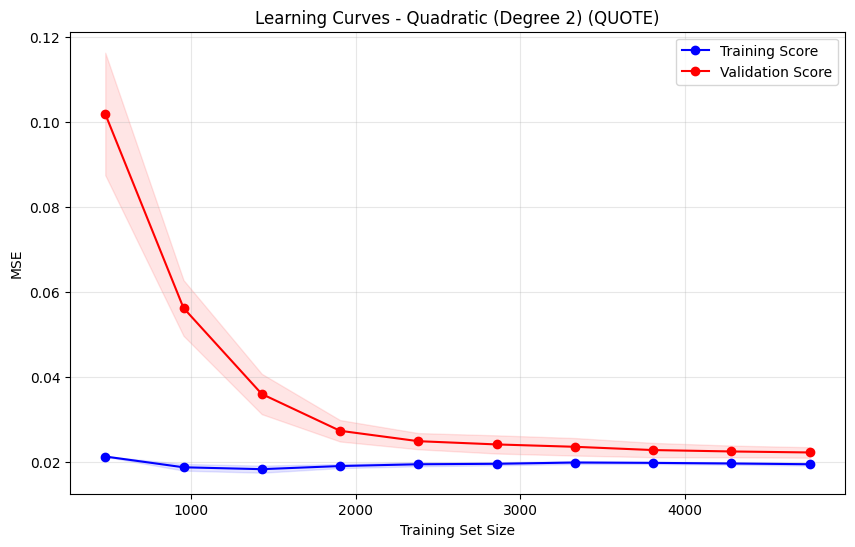

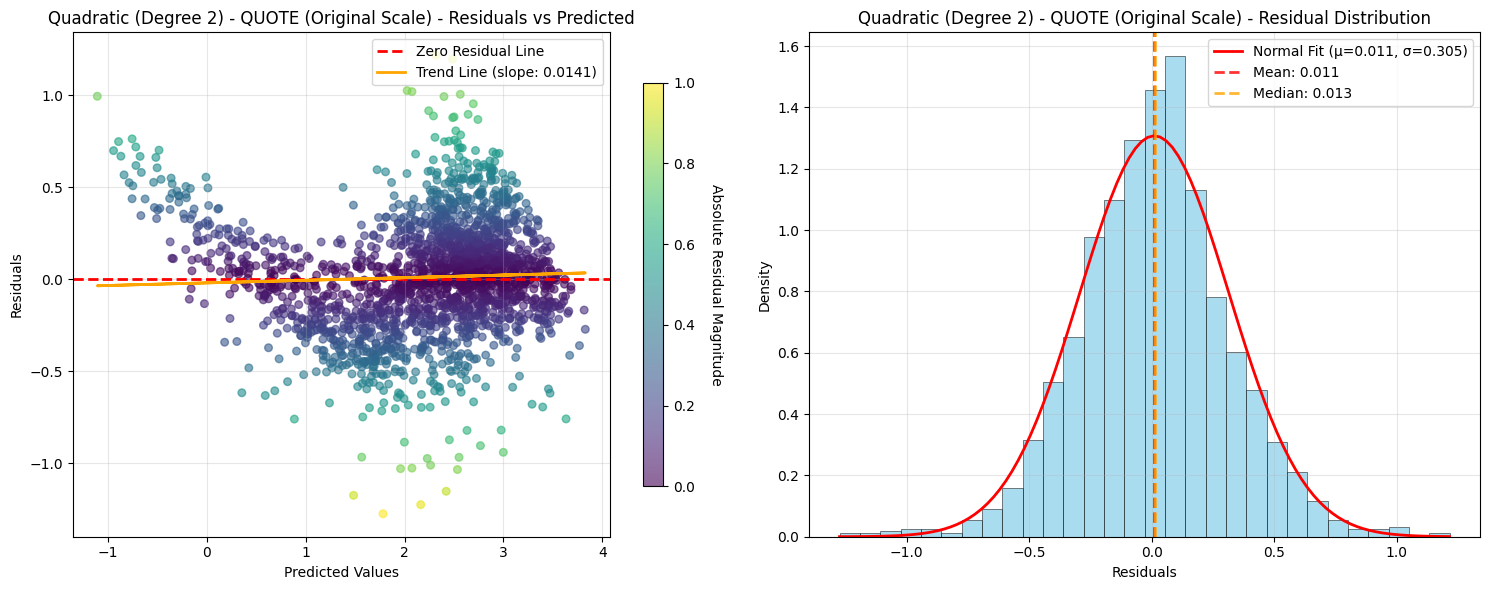

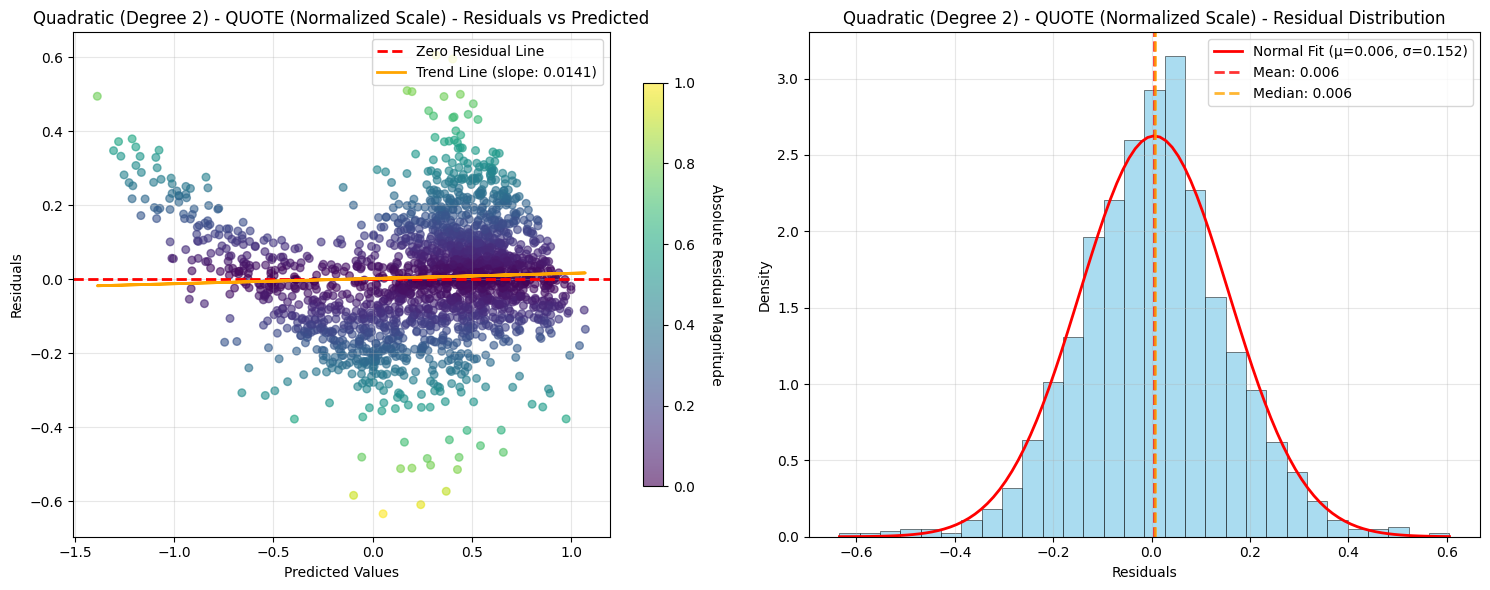

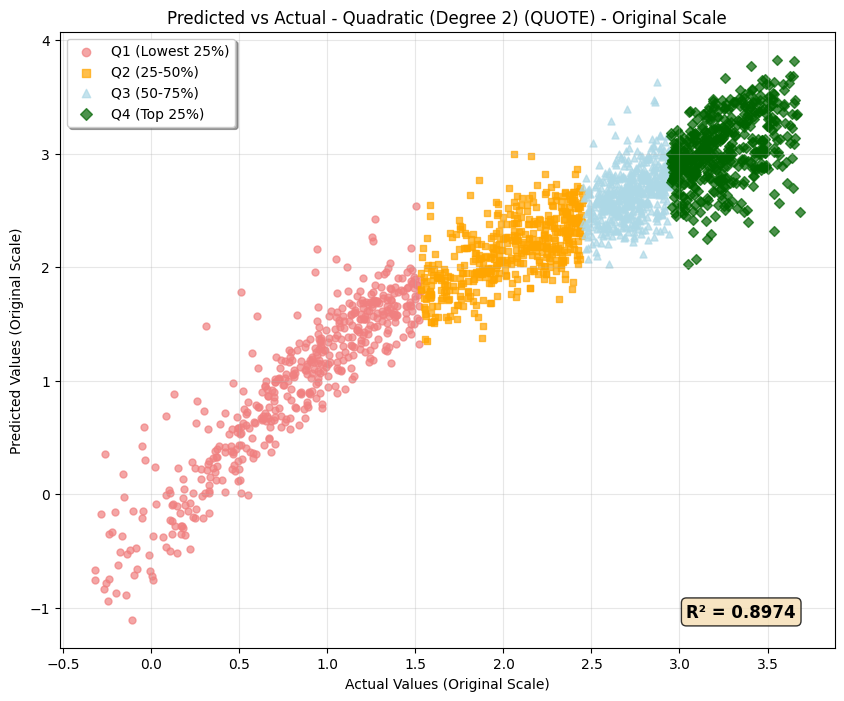

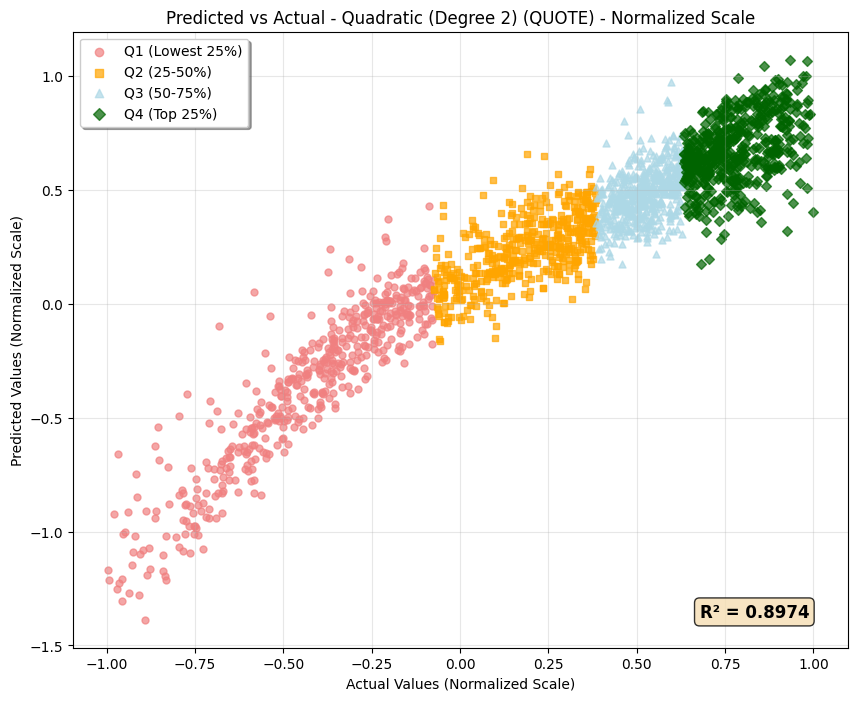


Creating visualizations for SCR - Quadratic (Degree 2)


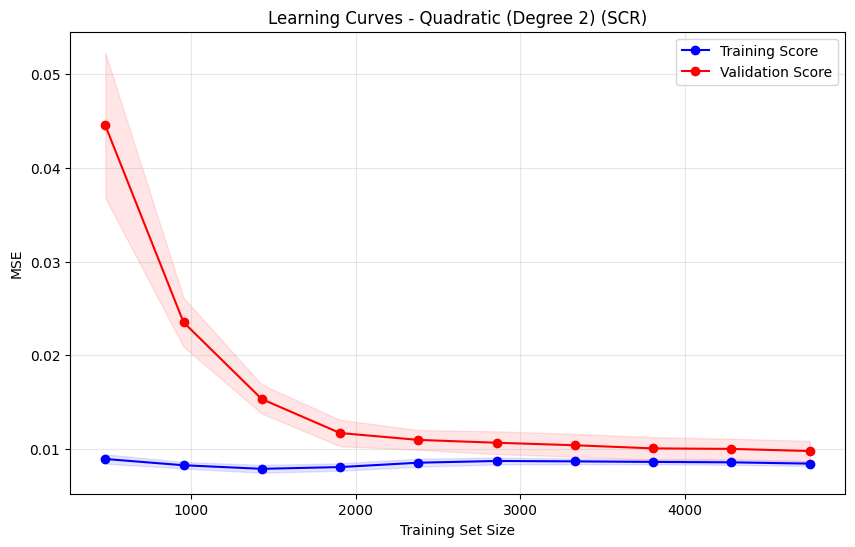

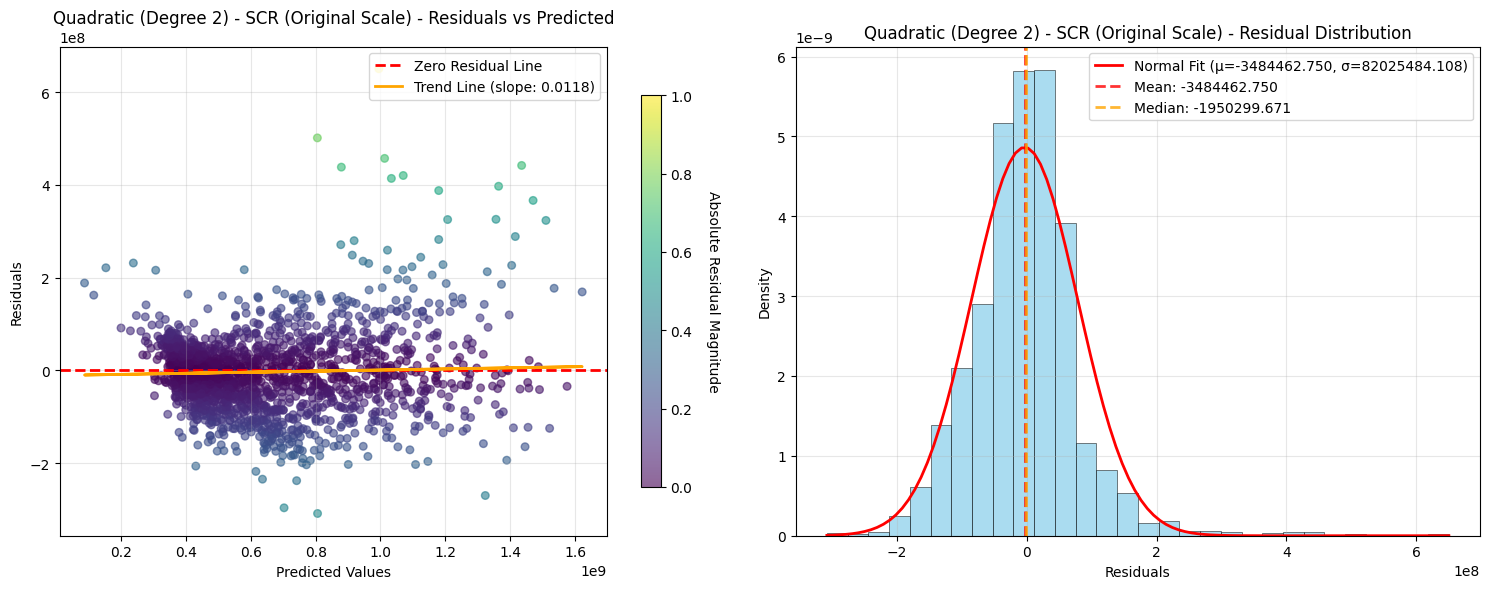

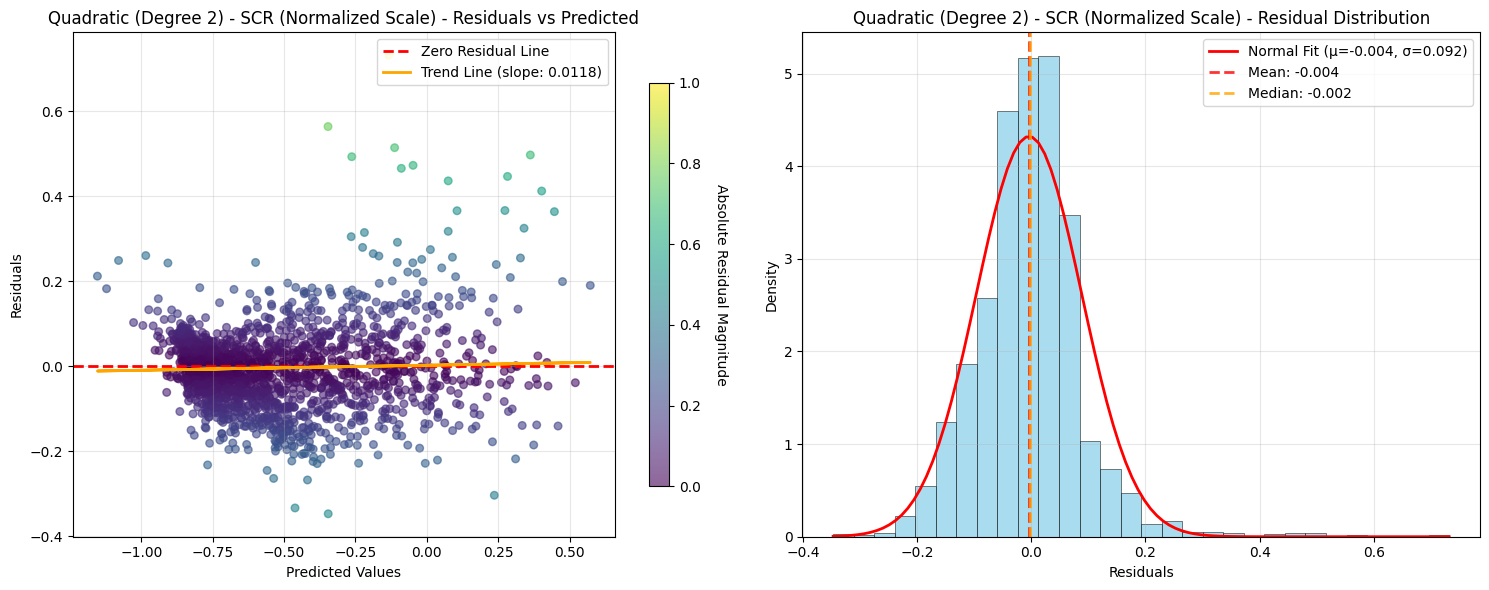

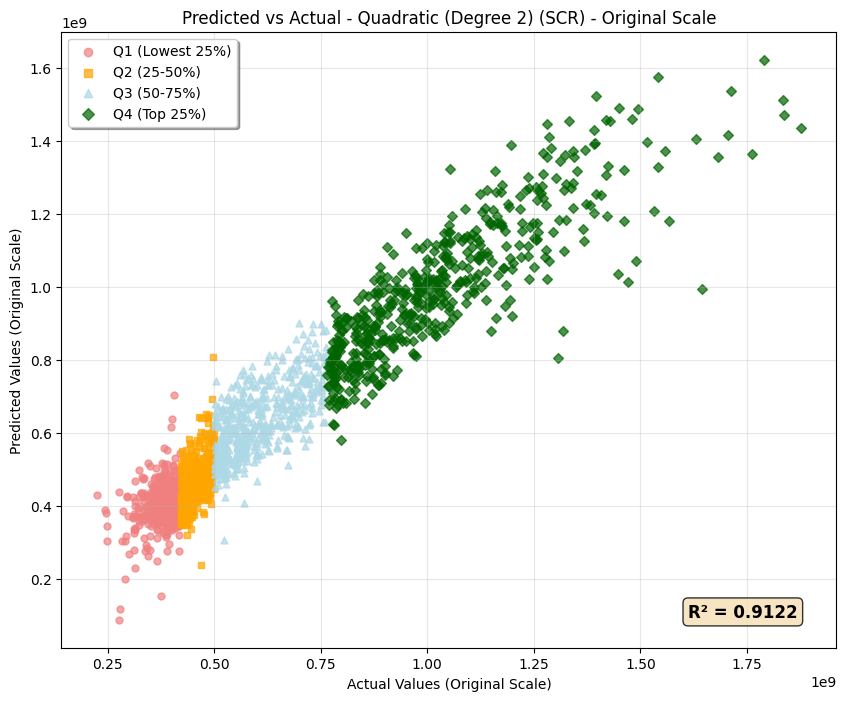

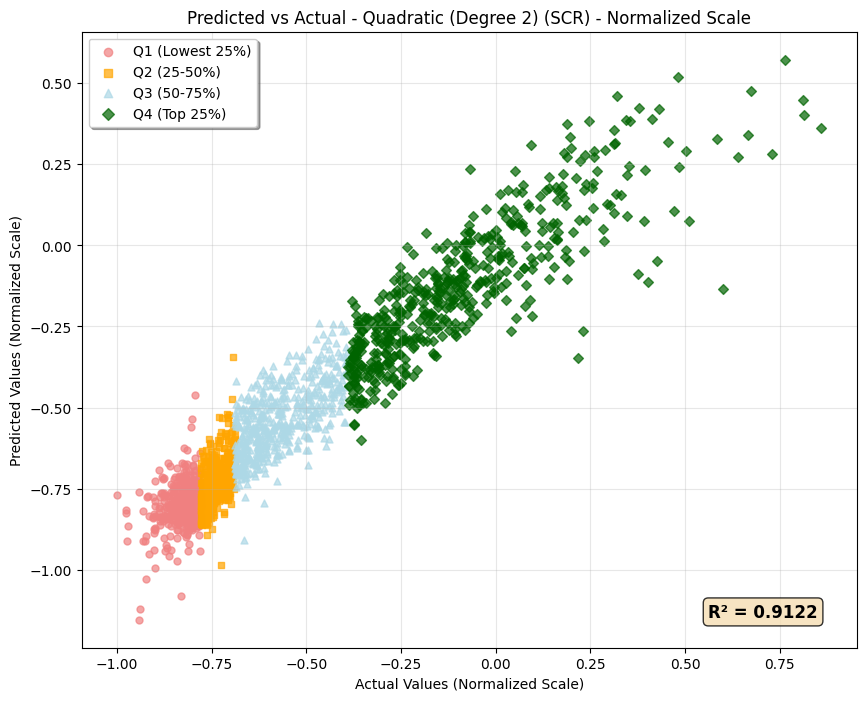


Creating visualizations for EM - Quadratic (Degree 2)


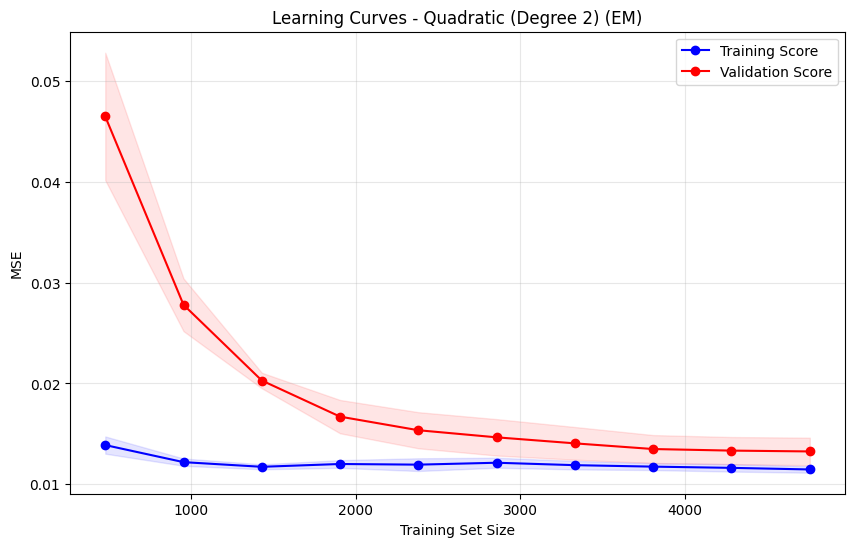

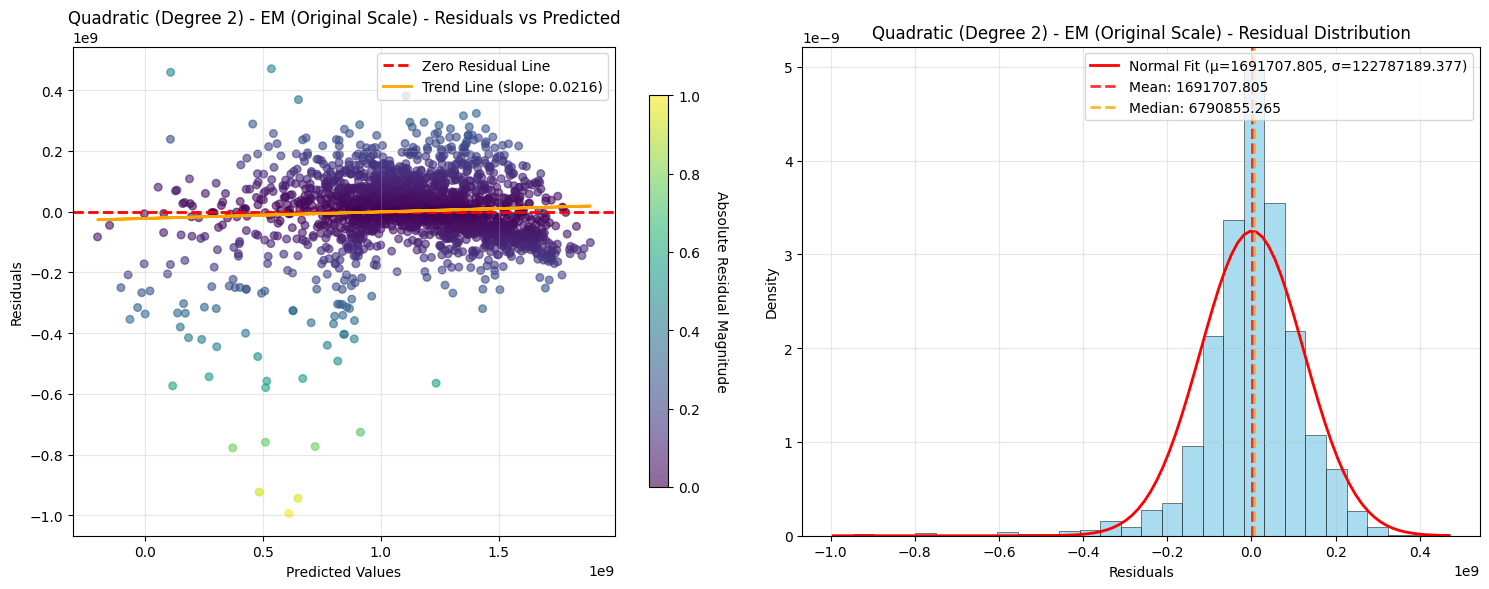

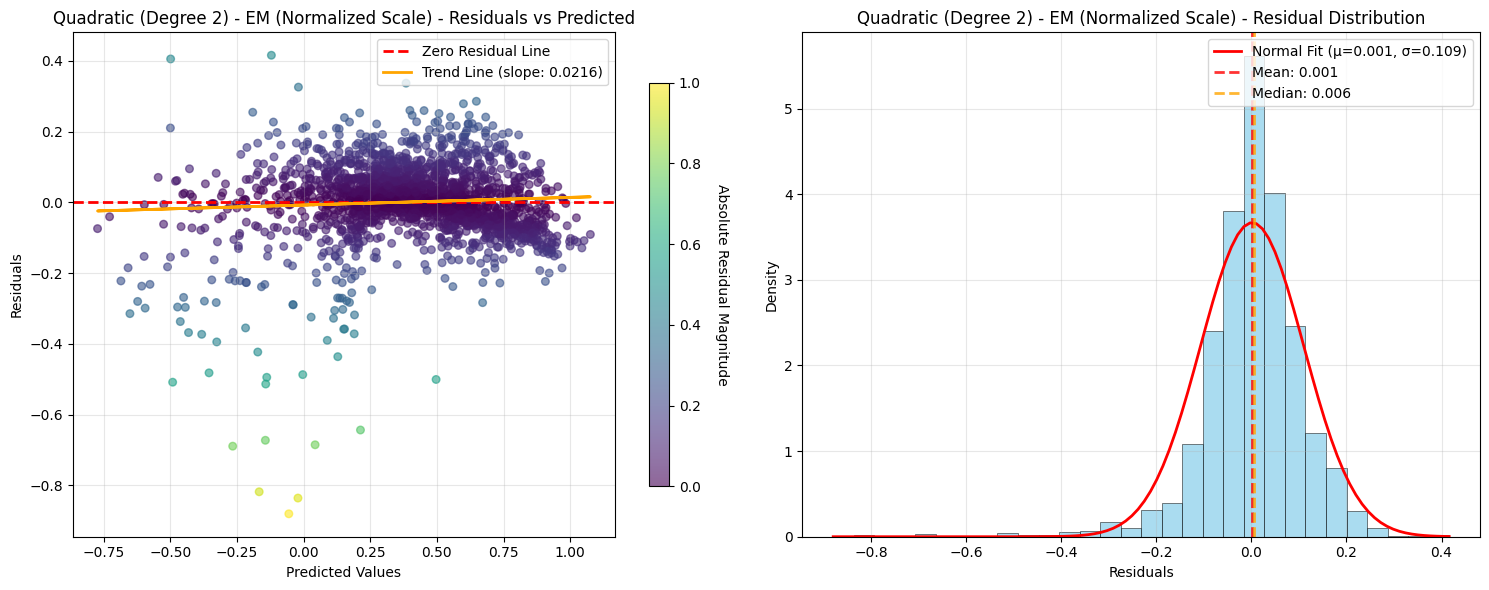

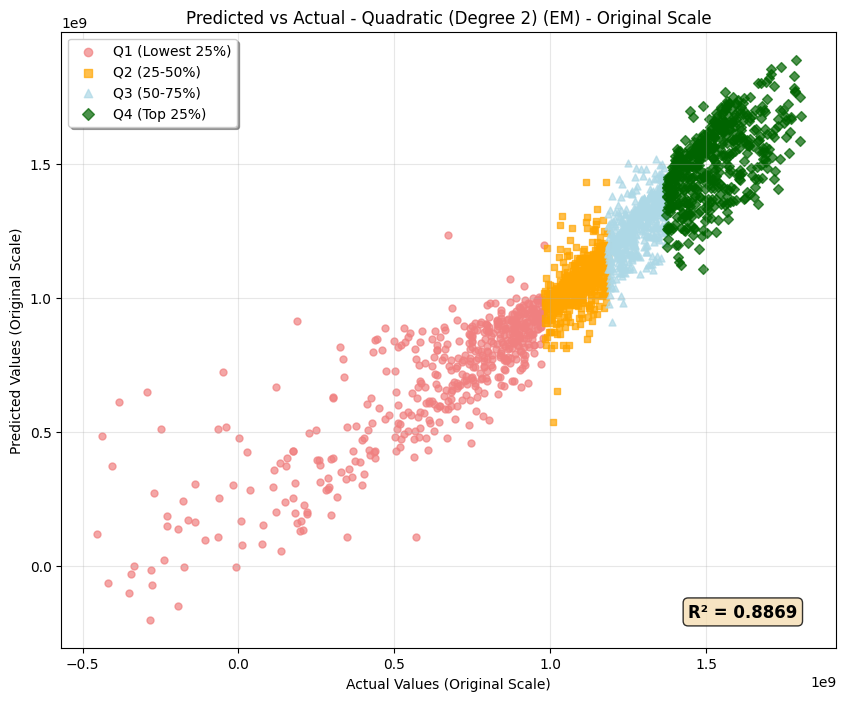

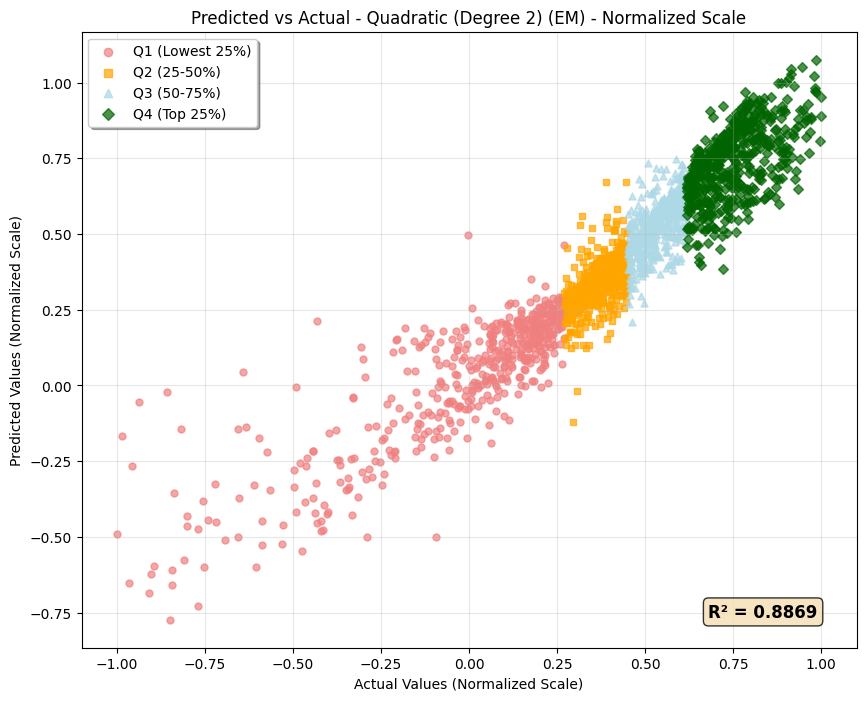


Creating visualizations for MULTI_OUTPUT - Quadratic (Degree 2) (Multi-Output)
  Skipping learning curves for multi-output model (complex to visualize)


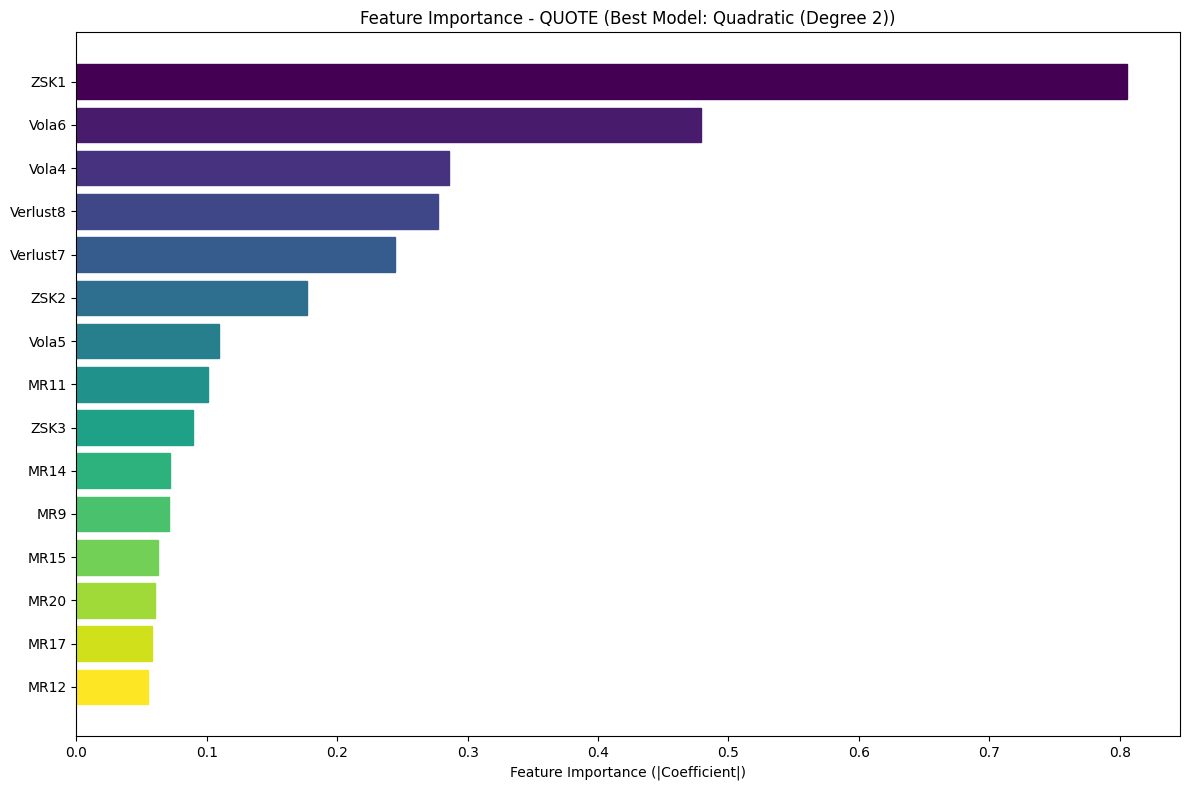

 Created feature importance plot for QUOTE


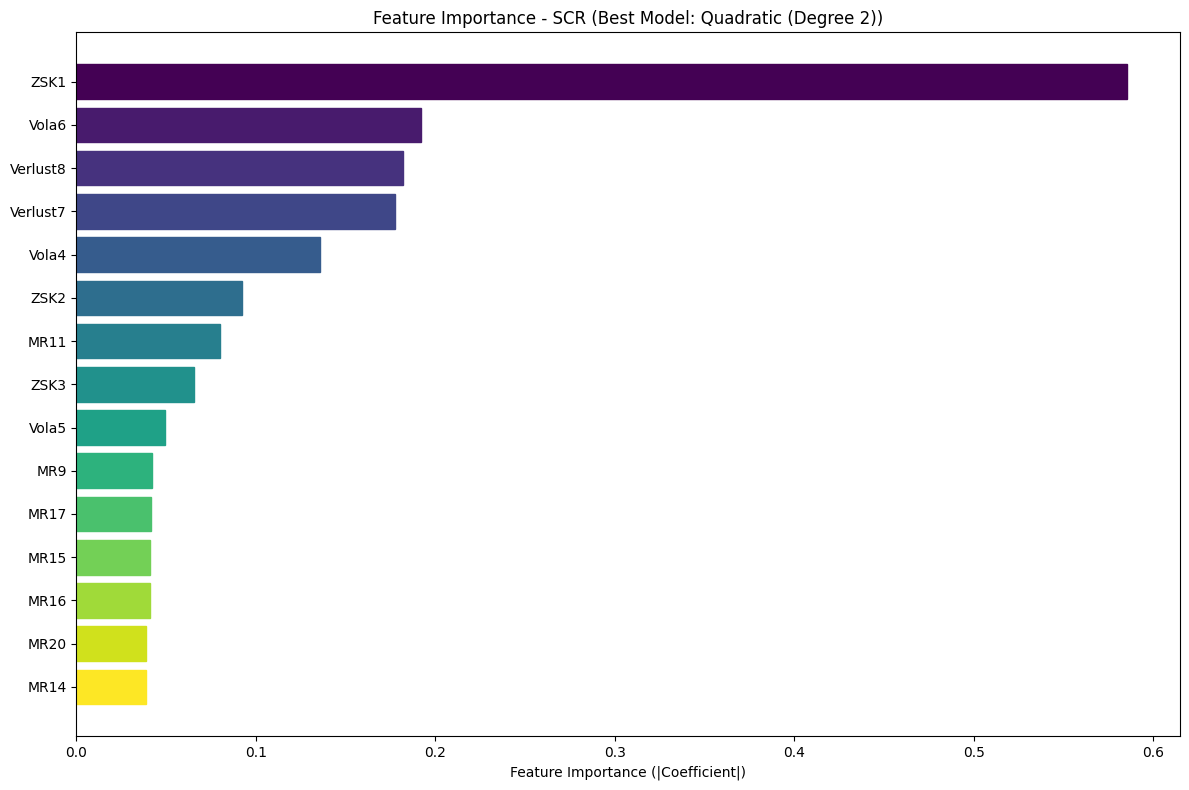

 Created feature importance plot for SCR


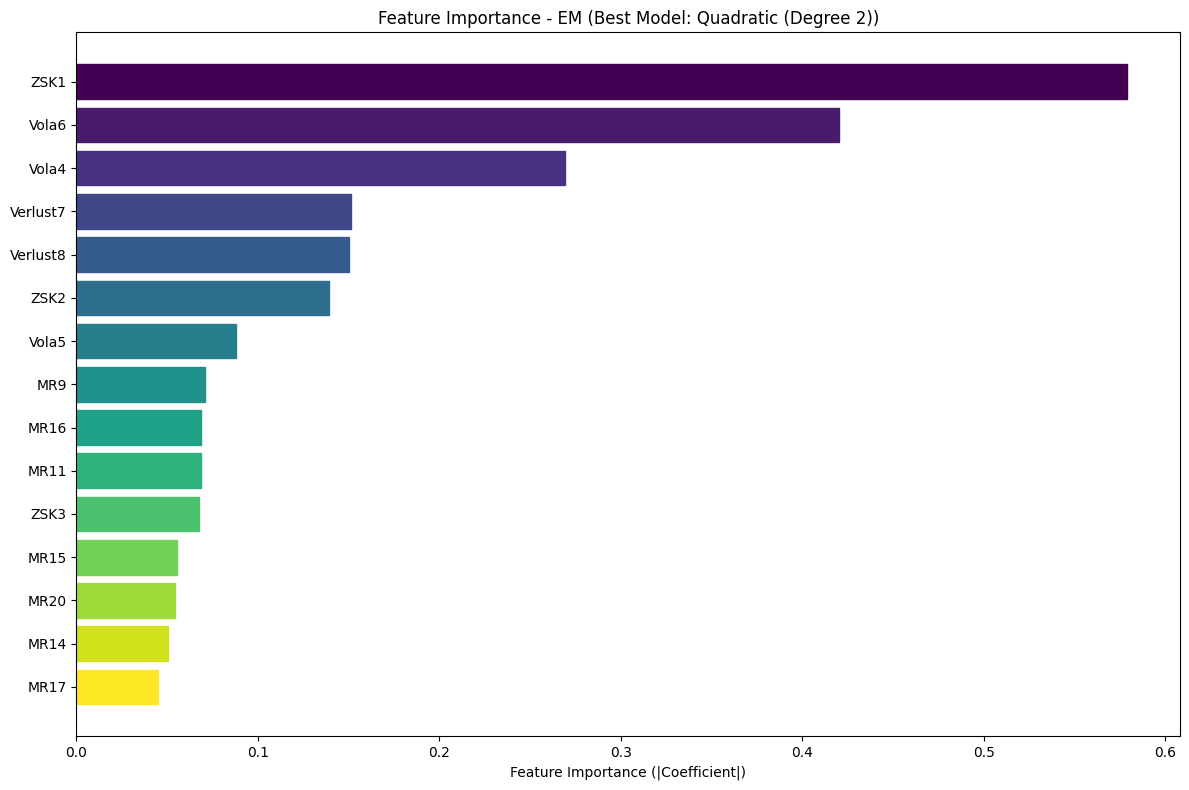

 Created feature importance plot for EM

Creating model performance comparison heatmap...


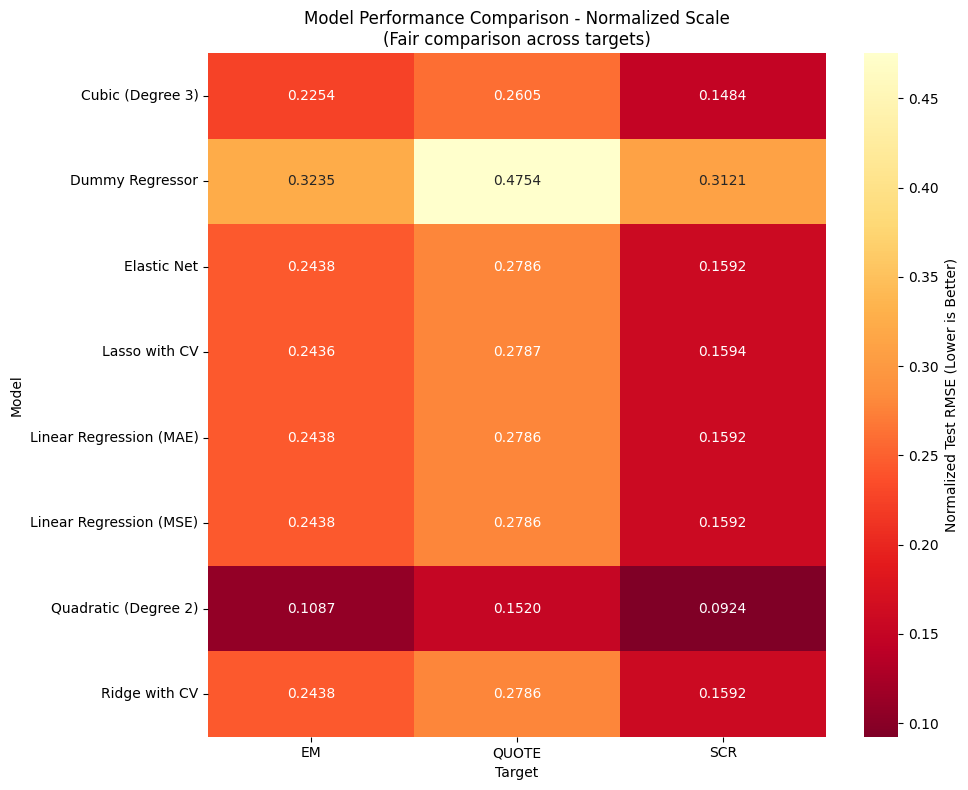

Created performance comparison heatmap

Creating regulatory performance visualization for Quote...


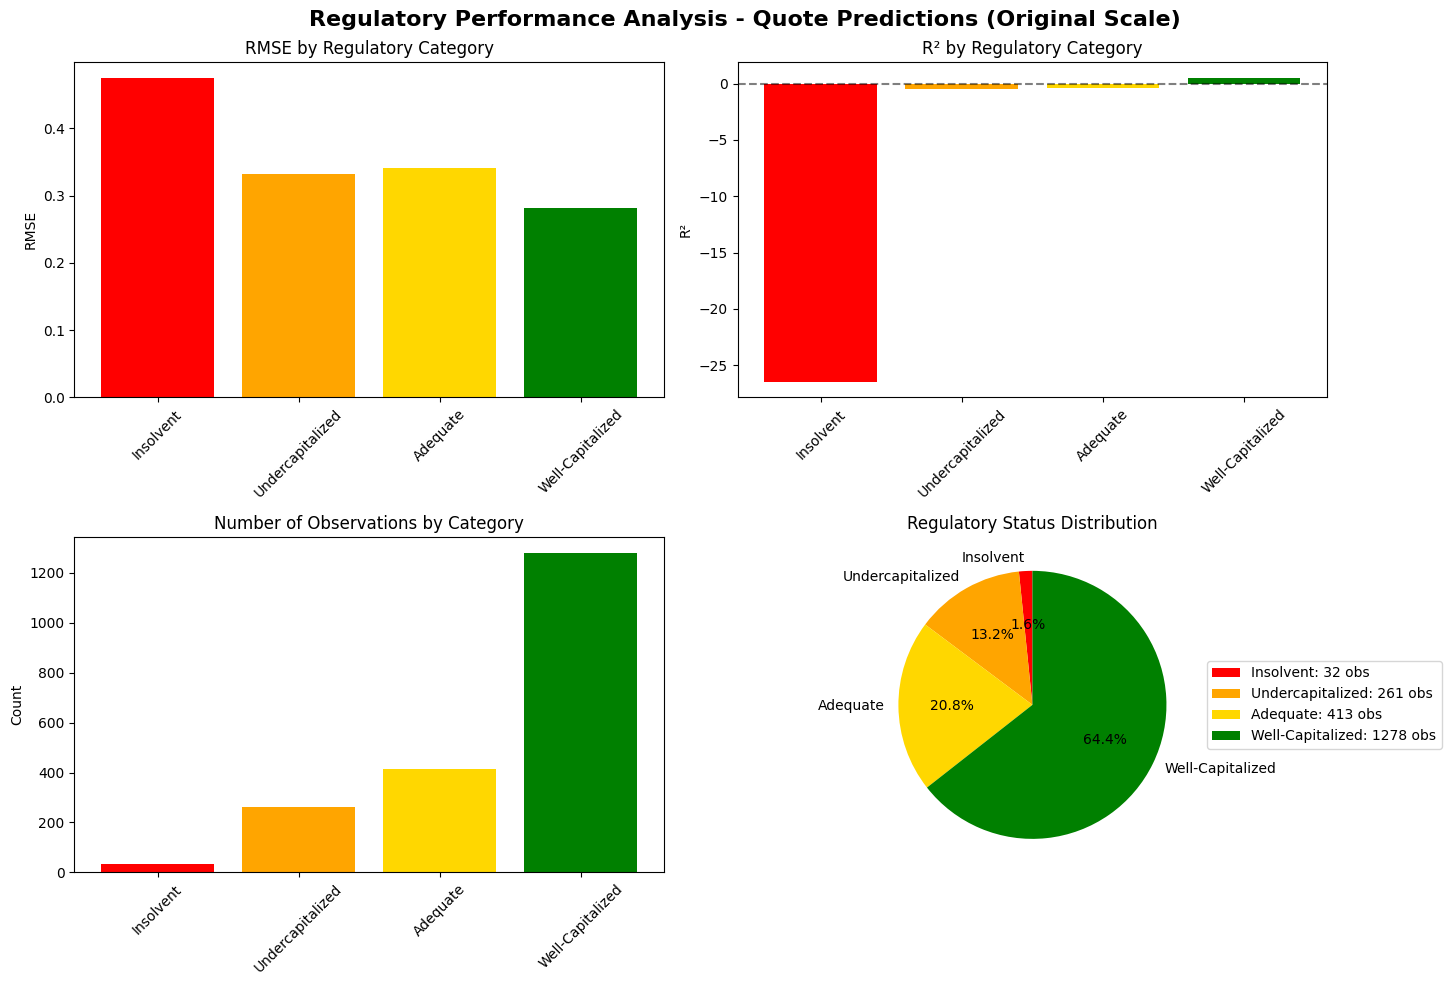

Created regulatory performance analysis


In [29]:
plt.style.use('default')
sns.set_palette("husl")

# Create visualizations for best models - BOTH SCALES
fig_counter = 1

for target, best_info in best_models.items():
    results = best_info['results']
    model_name = results['model_name']
    
    print(f"\nCreating visualizations for {target.upper()} - {model_name}")
    
    # earning Curves (only normalized - same as before)
    try:
        if target == 'multi_output':
            print(f"  Skipping learning curves for multi-output model (complex to visualize)")
            continue  # Skip learning curves for multi-output
        elif target == 'quote':
            y_train_target = y_quote_train
        elif target == 'scr':
            y_train_target = y_scr_train
        elif target == 'em':
            y_train_target = y_em_train
            
        fig = plot_learning_curves(results['model'], X_train, y_train_target)
        plt.title(f'Learning Curves - {model_name} ({target.upper()})')
        plt.savefig(f'figs/learning_curves_{target}_{fig_counter}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
    except Exception as e:
        print(f"Error creating learning curves: {str(e)}")
    
    # Residual Plots - BOTH SCALES
    try:
        if target == 'multi_output':
            # For multi-output, create plots for each target
            for i, sub_target in enumerate(['SCR', 'EM']):
                y_true = results['actuals']['test'].iloc[:, i]
                y_pred = results['predictions']['test'][:, i]
                
                fig = plot_residuals(y_true, y_pred, f"{model_name} - {sub_target}")
                plt.savefig(f'figs/residuals_{target}_{sub_target}_{fig_counter}.png', dpi=300, bbox_inches='tight')
                plt.show()
        else:
            # Original scale residuals
            y_true_orig = results['actuals']['test']
            y_pred_orig = results['predictions']['test']
            
            fig = plot_residuals(y_true_orig, y_pred_orig, f"{model_name} - {target.upper()} (Original Scale)")
            plt.savefig(f'figs/residuals_{target}_original_{fig_counter}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Normalized scale residuals
            if 'test_norm' in results['actuals'] and 'test_norm' in results['predictions']:
                y_true_norm = results['actuals']['test_norm']
                y_pred_norm = results['predictions']['test_norm']
                
                fig = plot_residuals(y_true_norm, y_pred_norm, f"{model_name} - {target.upper()} (Normalized Scale)")
                plt.savefig(f'figs/residuals_{target}_normalized_{fig_counter}.png', dpi=300, bbox_inches='tight')
                plt.show()
            
    except Exception as e:
        print(f"Error creating residual plots: {str(e)}")
    
    # Predicted vs Actual 
    try:
        if target == 'multi_output':
            # For multi-output, create plots for each target  
            for i, sub_target in enumerate(['SCR', 'EM']):
                y_true = results['actuals']['test'].iloc[:, i]
                y_pred = results['predictions']['test'][:, i]
                
                plt.figure(figsize=(10, 8))  
                fig = plot_predicted_vs_actual(y_true, y_pred, 
                                            f"Predicted vs Actual - {model_name} ({sub_target})", 
                                            "normalized", target_scalers)  
                plt.savefig(f'figs/pred_vs_actual_{target}_{sub_target}_{fig_counter}.png', dpi=300, bbox_inches='tight')
                plt.show()
        else:
            # Original scale scatter plot
            y_true_orig = results['actuals']['test']
            y_pred_orig = results['predictions']['test']
            
            plt.figure(figsize=(10, 8))  
            fig = plot_predicted_vs_actual(y_true_orig, y_pred_orig, 
                                        f"Predicted vs Actual - {model_name} ({target.upper()})", 
                                        "original", target_scalers)  
            plt.savefig(f'figs/pred_vs_actual_{target}_original_{fig_counter}.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            # Normalized scale scatter plot
            if 'test_norm' in results['actuals'] and 'test_norm' in results['predictions']:
                y_true_norm = results['actuals']['test_norm']
                y_pred_norm = results['predictions']['test_norm']
                
                plt.figure(figsize=(10, 8))  
                fig = plot_predicted_vs_actual(y_true_norm, y_pred_norm, 
                                            f"Predicted vs Actual - {model_name} ({target.upper()})", 
                                            "normalized", target_scalers) 
                plt.savefig(f'figs/pred_vs_actual_{target}_normalized_{fig_counter}.png', dpi=300, bbox_inches='tight')
                plt.show()
            
    except Exception as e:
        print(f"Error creating predicted vs actual plots: {str(e)}")
    fig_counter += 1

# Feature Importance Plots
for target, importance_result in feature_importance_results.items():
    try:
        plt.figure(figsize=(12, 8))
        
        # Plot top 15 original features
        top_features = importance_result['aggregated_importance'].head(15)
        
        if 'Total_Importance' in top_features.columns:
            importance_col = 'Total_Importance'
        else:
            importance_col = 'Importance'
            
        plt.barh(range(len(top_features)), top_features[importance_col])
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Feature Importance (|Coefficient|)')
        plt.title(f'Feature Importance - {target.upper()} (Best Model: {best_models[target]["results"]["model_name"]})')
        plt.gca().invert_yaxis()
        
        # Color bars by importance level
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
        bars = plt.gca().containers[0]
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        plt.tight_layout()
        plt.savefig(f'figs/feature_importance_{target}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f" Created feature importance plot for {target.upper()}")
        
    except Exception as e:
        print(f"Error creating feature importance plot for {target}: {str(e)}")

# Performance Comparison Heatmap (enhanced to show which scale is used)
try:
    print(f"\nCreating model performance comparison heatmap...")
    
    # Collect NORMALIZED RMSE data for fair comparison
    performance_data = []
    
    for target in ['quote', 'scr', 'em']:
        target_results = all_results[target]
        for model_key, results in target_results.items():
            if results is not None:
                # Use normalized RMSE for fair comparison
                val_rmse = results['metrics'].get('val_norm_RMSE', results['metrics'].get('val_RMSE', np.nan))
                test_rmse = results['metrics'].get('test_norm_RMSE', results['metrics'].get('test_RMSE', np.nan))
                
                performance_data.append({
                    'Target': target.upper(),
                    'Model': results['model_name'],
                    'Validation_RMSE': val_rmse,
                    'Test_RMSE': test_rmse
                })
    
    perf_df = pd.DataFrame(performance_data)
    
    # Create pivot table for heatmap
    heatmap_data = perf_df.pivot(index='Model', columns='Target', values='Test_RMSE')
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd_r', 
                cbar_kws={'label': 'Normalized Test RMSE (Lower is Better)'})
    plt.title('Model Performance Comparison - Normalized Scale\n(Fair comparison across targets)')
    plt.tight_layout()
    plt.savefig('figs/model_performance_heatmap_normalized.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Created performance comparison heatmap")
    
except Exception as e:
    print(f"Error creating performance heatmap: {str(e)}")

# Regulatory Performance Analysis for Quote (original scale)
if 'quote' in best_models:
    try:
        print(f"\nCreating regulatory performance visualization for Quote...")
        
        quote_results = best_models['quote']['results']
        regulatory_metrics = quote_results['metrics'].get('regulatory_test', {})
        
        if regulatory_metrics:
            categories = list(regulatory_metrics.keys())
            rmse_values = [regulatory_metrics[cat]['RMSE'] for cat in categories]
            r2_values = [regulatory_metrics[cat]['R2'] for cat in categories]
            counts = [regulatory_metrics[cat]['count'] for cat in categories]
            
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
            fig.suptitle('Regulatory Performance Analysis - Quote Predictions (Original Scale)', fontsize=16, fontweight='bold')
            
            # RMSE by regulatory category
            bars1 = ax1.bar(categories, rmse_values, color=['red', 'orange', 'gold', 'green'])
            ax1.set_title('RMSE by Regulatory Category')
            ax1.set_ylabel('RMSE')
            ax1.tick_params(axis='x', rotation=45)
            
            # R² by regulatory category
            bars2 = ax2.bar(categories, r2_values, color=['red', 'orange', 'gold', 'green'])
            ax2.set_title('R² by Regulatory Category')
            ax2.set_ylabel('R²')
            ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax2.tick_params(axis='x', rotation=45)
            
            # Count by regulatory category
            bars3 = ax3.bar(categories, counts, color=['red', 'orange', 'gold', 'green'])
            ax3.set_title('Number of Observations by Category')
            ax3.set_ylabel('Count')
            ax3.tick_params(axis='x', rotation=45)
            
            # Pie chart with better legend
            wedges, texts, autotexts = ax4.pie(counts, labels=categories, autopct='%1.1f%%', 
                    colors=['red', 'orange', 'gold', 'green'], startangle=90)
            ax4.set_title('Regulatory Status Distribution')
            
            # Add enhanced legend for pie chart
            ax4.legend(wedges, [f'{cat}: {count} obs' for cat, count in zip(categories, counts)],
                      loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
            
            plt.tight_layout()
            plt.savefig('figs/regulatory_performance_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print(f"Created regulatory performance analysis")
        
    except Exception as e:
        print(f"Error creating regulatory performance visualization: {str(e)}")


## SECTION 3.7: Saving Artifacts

In [30]:
# Create artifacts directory
artifacts_dir = Path('solvency_ml_artifacts')
artifacts_dir.mkdir(exist_ok=True)

# Save best models
for target, best_info in best_models.items():
    model_path = artifacts_dir / f'best_{target}_pipeline.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(best_info['results']['model'], f)
    print(f"Saved {target} model to {model_path}")

# Save comprehensive results summary
results_summary = {
    'timestamp': datetime.now().isoformat(),
    'data_shape': df.shape,
    'feature_columns': feature_cols,
    'target_columns': target_cols,
    'regulatory_distribution': {
        'insolvent': int((df['Quote'] < 0).sum()),
        'undercapitalized': int((df['Quote'] < 1).sum()),
        'well_capitalized': int((df['Quote'] > 2).sum()),
        'total': len(df)
    },
    'train_test_split': {
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'random_state': RANDOM_STATE
    },
    'best_models': {},
    'model_comparisons': {}
}

# Add best model results
for target, best_info in best_models.items():
    results_summary['best_models'][target] = {
        'model_name': best_info['results']['model_name'],
        'model_key': best_info['key'],
        'validation_rmse': float(best_info['val_rmse_norm']),
        'test_metrics': {k: float(v) if isinstance(v, (int, float, np.number)) else v 
                        for k, v in best_info['results']['metrics'].items() 
                        if k.startswith('test_') and isinstance(v, (int, float, np.number))}
    }

# Add feature importance results
for target, importance_result in feature_importance_results.items():
    if target in results_summary['best_models']:
        top_features = importance_result['aggregated_importance'].head(10)
        if 'Total_Importance' in top_features.columns:
            importance_col = 'Total_Importance'
        else:
            importance_col = 'Importance'
            
        results_summary['best_models'][target]['top_features'] = [
            {'feature': row['Feature'], 'importance': float(row[importance_col])}
            for _, row in top_features.iterrows()
        ]

# Add stability results
for target, stability_result in stability_results.items():
    if target in results_summary['best_models']:
        results_summary['best_models'][target]['stability_metrics'] = {
            'overall_rmse': float(stability_result['overall_rmse']),
            'overall_r2': float(stability_result['overall_r2']),
            'residual_std': float(stability_result['residual_std'])
        }

# Add comparison tables
results_summary['model_comparisons'] = {
    'quote': quote_comparison.to_dict('records') if not quote_comparison.empty else [],
    'scr': scr_comparison.to_dict('records') if not scr_comparison.empty else [],
    'em': em_comparison.to_dict('records') if not em_comparison.empty else [],
    'multi_output': multi_comparison.to_dict('records') if not multi_comparison.empty else []
}

# Save results summary
summary_path = artifacts_dir / 'models_report.json'
with open(summary_path, 'w') as f:
    json.dump(results_summary, f, indent=2, default=str)
print(f"Saved comprehensive results summary to {summary_path}")

# Save feature importance results separately
for target, importance_result in feature_importance_results.items():
    importance_path = artifacts_dir / f'feature_importance_{target}.csv'
    importance_result['aggregated_importance'].to_csv(importance_path, index=False)
    print(f"Saved feature importance for {target} to {importance_path}")


Saved quote model to solvency_ml_artifacts/best_quote_pipeline.pkl
Saved scr model to solvency_ml_artifacts/best_scr_pipeline.pkl
Saved em model to solvency_ml_artifacts/best_em_pipeline.pkl
Saved multi_output model to solvency_ml_artifacts/best_multi_output_pipeline.pkl
Saved comprehensive results summary to solvency_ml_artifacts/models_report.json
Saved feature importance for quote to solvency_ml_artifacts/feature_importance_quote.csv
Saved feature importance for scr to solvency_ml_artifacts/feature_importance_scr.csv
Saved feature importance for em to solvency_ml_artifacts/feature_importance_em.csv
